<a href="https://colab.research.google.com/github/stivenbg/PINNS/blob/main/DW_hmtz2_yeyi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import pandas as pd
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [2]:
#Ici je loads mes data pour contraindre ma solution à respecter la FEM
from google.colab import files
uploaded = files.upload()

Saving nodes_colocations.xlsx to nodes_colocations.xlsx


In [3]:
#Ici je recupère le maillage
import io
df = pd.read_excel(io.BytesIO(uploaded['nodes_colocations.xlsx']))
print(df);

             1         0
0     1.000000  1.000000
1     0.000000  1.000000
2     0.000000  0.000000
3     1.000000  0.020000
4     1.000000  0.040000
...        ...       ...
3429  0.465490  0.298860
3430  0.989930  0.010072
3431  0.010072  0.010072
3432  0.989930  0.989930
3433  0.010036  0.989960

[3434 rows x 2 columns]


In [4]:
#maillages fem, leur meshgrid reconstruit le maillage
x3=df.loc[:,1];  #axe 1 Ici x3 et x4 sont des series
x4=df.loc[:,0];  #axe 2


In [5]:
x3=x3.to_numpy() #ici je la convertie en ndarray parce que c'est une serie
x3=np.insert(x3, 0, 1) #je rajoute le premier élement qui manque, disparu pendant l'importation avec pandas
x4=x4.to_numpy()
x4=np.insert(x4, 0, 0) #dimension (3435,) on va transformer ce vecteur en dimension (3435,1) ave la sutie
x3=np.transpose(np.array([x3]))
x4=np.transpose(np.array([x4]))
X2, Y2 = np.meshgrid(x3,x4)

In [ ]:
x5=np.transpose(np.array([x3]))

In [21]:
#Importation des données de simulation
from google.colab import files
uploaded = files.upload()

Saving IA_pbdw_ok_ok.xlsx to IA_pbdw_ok_ok.xlsx


In [22]:
import io
df = pd.read_excel(io.BytesIO(uploaded['IA_pbdw_ok_ok.xlsx']))
print(df);
solution_EF=df.loc[:,'solution_EF'].to_numpy()
solution_PBDW= df.loc[:,'solution_PBDW'].to_numpy()
solution_PBDW_eta=df.loc[:,'solution_PBDW_eta'].to_numpy()
solution_PBDW_z=df.loc[:,'solution_PBDW_z'].to_numpy()
solution_EF_et_PBDW=df.loc[0:1,'solution_EF'].to_numpy()
solution_EF_et_PBDW=df.loc[:,'solution_EF':'solution_PBDW'].to_numpy()

      solution_EF  solution_PBDW  solution_PBDW_eta  solution_PBDW_z
0        0.712350       0.717750            0.37965          0.33810
1        0.954060       0.858890            0.19041          0.66848
2        0.665110       0.669710            0.14421          0.52550
3        0.423390       0.327130            0.13203          0.19509
4        0.711630       0.720570            0.38183          0.33874
...           ...            ...                ...              ...
3430    -0.009714       0.003076           -0.10197          0.10504
3431     0.711540       0.717330            0.37912          0.33821
3432     0.422560       0.327010            0.13204          0.19497
3433     0.953290       0.858920            0.19042          0.66849
3434     0.664320       0.668930            0.14364          0.52528

[3435 rows x 4 columns]


In [ ]:
#parametter
mu=5
epsilon=0.0001

# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (x,t)
and #outputs = 1

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,100)
        self.hidden_layer2 = nn.Linear(100,100)
        self.hidden_layer3 = nn.Linear(100,100)
        self.hidden_layer4 = nn.Linear(100,100)
        self.hidden_layer5 = nn.Linear(100,100)
        self.output_layer = nn.Linear(100,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [ ]:
#parametter
mu=5
epsilon=0.0001

# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (x,t)
and #outputs = 1

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,50)
        self.hidden_layer2 = nn.Linear(50,50)
        self.hidden_layer3 = nn.Linear(50,50)
        self.hidden_layer4 = nn.Linear(50,50)
        self.hidden_layer5 = nn.Linear(50,50)
        self.output_layer = nn.Linear(50,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.relu(self.hidden_layer1(inputs))
        layer2_out = torch.relu(self.hidden_layer2(layer1_out))
        layer3_out = torch.relu(self.hidden_layer3(layer2_out))
        layer4_out = torch.relu(self.hidden_layer4(layer3_out))
        layer5_out = torch.relu(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        #output = torch.sigmoid(self.output_layer(layer5_out)) # je normalise la sortie entre 0 et 1
        return output

In [84]:
#parametter
mu=5
epsilon=0.0001

# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (x,t)
and #outputs = 1

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,100)
        self.hidden_layer2 = nn.Linear(100,100)
        self.hidden_layer3 = nn.Linear(100,100)
        self.hidden_layer4 = nn.Linear(100,100)
        self.hidden_layer5 = nn.Linear(100,100)
        self.output_layer = nn.Linear(100,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = torch.sigmoid(self.output_layer(layer5_out)) ## j'active avec une sigmoid pour avoir une échelle de la sortie normalisée
        return output

In [85]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)


In [73]:
### PDE as loss function. Thus would use the network which we call as u_theta
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    #u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    #u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    #u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t.sum(), t, create_graph=True)[0]


    #u_xx_1 = u_xx[:,0]
    #u_xx_2 = u_xx[:,1]


    #pde = u_x - 2*u_t - u
    pde= -(u_xx+u_tt)-mu**2*u
    #pde= -mu**2*u -(u_xx_1) #+u_xx_2)
    #pde= -(u_xx)-mu**2*u
    #pde=torch.tensor(1+epsilon*mu, dtype=torch.complex32)*(u_xx+u_tt)-mu**2*u
    


    return pde

In [ ]:
#torch.tensor(1+epsilon*mu, dtype=torch.complex32)
#Data high fidelity solution
ms_x3,ms_x4=np.meshgrid(x3,x4)
#A faire !
ms_u_fem=solution_EF.reshape(ms_x3.shape) #Il me faut avoir les solution elemnts finis sous forme de matrice et non de vecteur. Comment faire pour créer le mapping ?

ValueError: ignored

In [ ]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
#x_bc = np.random.uniform(low=0.0, high=1.0, size=(1000,1))
#t_bc = np.random.uniform(low=0.0, high=1.0, size=(15,1))
x_bc=np.array([[0] for i in range(10)])
t_bc=x_bc
ms_x_bc, ms_t_bc= np.meshgrid(x_bc, t_bc)
a_1 = 1 
a_2 = 1
#Dans le cas de mon pb toutes les BC sont nulles
#a_1 = 0
#a_2 = 0
# compute u based on BC
#u_bc = 60*np.exp(-3*x_bc)
u_bc = np.sin(a_1 * np.pi *ms_x_bc) * np.sin(a_2 * np.pi * ms_t_bc) #solution chosen for convinience 
#u_bc = np.sin(a_1 * np.pi *x_bc) * np.sin(a_2 * np.pi * t_bc) #solution chosen for convinience 
#u_bc = np.sin(0 * np.pi *x_bc) * np.sin(0 * np.pi * t_bc) #solution chosen for convinience 

ms_u_bc = u_bc.reshape(ms_x_bc.shape)

In [ ]:
#Boundaries conditions
#Training data 
#Ici je definis les contours sur lesquels je vais définir mes conditions aux limites.

#X2,Y2 sont deux meshgrid matrices de coordonnées, issues des coordonées du maillage originel.
#On va extraire les 4 côtés du domaine. 
a6=0

#x_bc=np.array([[0] for i in range(10)])
#t_bc=x_bc
#ms_x_bc, ms_t_bc= np.meshgrid(x_bc, t_bc)

a_1 = 1 
a_2 = 1

#Dans le cas de mon pb toutes les BC sont nulles
#a_1 = 0
#a_2 = 0

# compute u based on BC
#u_bc = 60*np.exp(-3*x_bc)
u_bc = a6*np.sin(a_1 * np.pi *X2) * np.sin(a_2 * np.pi *Y2) #solution chosen for convinience 
#u_bc = np.sin(a_1 * np.pi *x_bc) * np.sin(a_2 * np.pi * t_bc) #solution chosen for convinience 
#u_bc = np.sin(0 * np.pi *x_bc) * np.sin(0 * np.pi * t_bc) #solution chosen for convinience 

ms_u_bc = u_bc.reshape(ms_x_bc.shape)


def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X2[:,0][:,None], Y2[:,0][:,None])) #côté gauche
    leftedge_u = u_bc[:,0][:,None]
    
    rightedge_x = np.hstack((X2[:,-1][:,None], Y2[:,-1][:,None])) #côté droit
    rightedge_u = u_bc[:,-1][:,None]
    
    topedge_x = np.hstack((X2[0,:][:,None], Y2[0,:][:,None])) #côté haut
    topedge_u = u_bc[0,:][:,None]
    
    bottomedge_x = np.hstack((X2[-1,:][:,None], Y2[-1,:][:,None])) #côté bas
    bottomedge_u = u_bc[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) #concatenation horizontale de tous les côtés
    all_u_train =a6* np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  #Les valeurs aux bords du champ primal
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    return  X_u_train, u_train

In [ ]:
ms_x_bc.shape,u_bc.shape

((10, 10), (10, 10))

In [39]:
def training_bc(N_u):
  a6=0
  a_1 = 1 
  a_2 = 1
  #Dans le cas de mon pb toutes les BC sont nulles
  #a_1 = 0
  #a_2 = 0
  # compute u based on BC
  #u_bc = 60*np.exp(-3*x_bc)
  u_bc = a6*np.sin(a_1 * np.pi *X2) * np.sin(a_2 * np.pi *Y2)
  leftedge_x = np.hstack((X2[:,0][:,None], Y2[:,0][:,None])) #côté gauche
  leftedge_u = u_bc[:,0][:,None]
  rightedge_x = np.hstack((X2[:,-1][:,None], Y2[:,-1][:,None])) #côté droit
  rightedge_u = u_bc[:,-1][:,None]
  topedge_x = np.hstack((X2[0,:][:,None], Y2[0,:][:,None])) #côté haut
  topedge_u = u_bc[0,:][:,None]
  bottomedge_x = np.hstack((X2[-1,:][:,None], Y2[-1,:][:,None])) #côté bas
  bottomedge_u = u_bc[-1,:][:,None]
  all_x_bc = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) #concatenation horizontale des coordonnées de tous les côtés
  all_u_bc =a6* np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  #Les valeurs aux bords du champ primal
  #choose random N_u points for training
  idx = np.random.choice(all_x_bc.shape[0], N_u, replace=False) 

  all_x_bc = all_x_bc[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
  all_u_bc = all_u_bc[idx[0:N_u],:]    #choose corresponding u

  return all_x_bc, all_u_bc


(array([[0.010036, 0.72138 ],
        [0.36125 , 0.      ],
        [1.      , 0.51171 ],
        ...,
        [1.      , 0.063203],
        [0.47083 , 0.      ],
        [1.      , 0.85788 ]]), array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]))

In [64]:
#x3=np.transpose(np.array([x3]))
#x_bc,t_bc = (pt_bc[:,0]),(pt_bc[:,1])
#x_bc = (pt_bc[:,0])
#np.transpose(np.array([pt_bc[:,0]])).shape

AttributeError: ignored

In [ ]:





### (3) Training / Fitting
iterations = 5000
#iterations = 2000

previous_validation_loss = 99999999.0
for epoch in range(iterations):
  optimizer.zero_grad() # to make the gradients zero

  #Loss based on high fidelity FEM simulation
  #Ici je vais fit la sortie du réseau NN(xfem1,xfem2) à u_fem.

  pt_x_fem1 = Variable(torch.from_numpy(x3).float(), requires_grad=False).to(device) 
  pt_x_fem2= Variable(torch.from_numpy(x4).float(), requires_grad=False).to(device)
  pt_u_fem = Variable(torch.from_numpy(solution_EF).float(), requires_grad=False).to(device)

  net_fem_out=net(pt_x_fem1, pt_x_fem2)
  mse_fem=mse_cost_function(net_fem_out, pt_u_fem )

  
  # Loss based on PDE
  x_collocation = np.random.uniform(low=0.0, high=1.0, size=(20000,1))
  t_collocation = np.random.uniform(low=0.0, high=1.0, size=(20000,1))
  all_zeros = np.zeros((20000,1))
  
  
  pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
  pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
  pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
  
  f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
  mse_f = mse_cost_function(f_out, pt_all_zeros)


    # Loss based on boundary conditions
  
  # je recupère les paramètres des BC et je les scinde en 2 deux puisque le NN prend 2 inputs
  # N_u=len(all_u_bc)=13740
  N_u=3000
  pt_bc, u_bc = training_bc(N_u)
  #x_bc,t_bc = pt_bc[:,0],pt_bc[:,1] pas bon ici, il nous faut un format ligne colonne
  #np.transpose(np.array([pt_bc[:,0]])) on applique cette transformation pour convertir
  x_bc,t_bc = np.transpose(np.array([pt_bc[:,0]])),np.transpose(np.array([pt_bc[:,1]]))



  pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
  pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
  pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
  #pt_u_bc = Variable(torch.from_numpy(ms_u_bc).float(), requires_grad=False).to(device)




  net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
  mse_u = mse_cost_function(net_bc_out, pt_u_bc)


  
  # Combining the loss functions
  loss = mse_fem + mse_u  # mse_f#    # la fonction cout à minimiser vis-à-vis du modèles, des BC, de la FEM
  #loss = mse_f 
  #loss=mse_u
  
  
  loss.backward() # This is for computing gradients using backward propagation
  optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

  with torch.autograd.no_grad():
    print(epoch,"Traning Loss:",loss.data);
    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 Traning Loss: tensor(0.2478, device='cuda:0')
1 Traning Loss: tensor(0.2094, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2 Traning Loss: tensor(0.1748, device='cuda:0')
3 Traning Loss: tensor(0.1469, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4 Traning Loss: tensor(0.1301, device='cuda:0')
5 Traning Loss: tensor(0.1245, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


6 Traning Loss: tensor(0.1264, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


7 Traning Loss: tensor(0.1314, device='cuda:0')
8 Traning Loss: tensor(0.1360, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


9 Traning Loss: tensor(0.1394, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


10 Traning Loss: tensor(0.1412, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


11 Traning Loss: tensor(0.1417, device='cuda:0')
12 Traning Loss: tensor(0.1409, device='cuda:0')
13 Traning Loss: tensor(0.1391, device='cuda:0')
14 Traning Loss: tensor(0.1365, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


15 Traning Loss: tensor(0.1333, device='cuda:0')
16 Traning Loss: tensor(0.1298, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


17 Traning Loss: tensor(0.1265, device='cuda:0')
18 Traning Loss: tensor(0.1240, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


19 Traning Loss: tensor(0.1230, device='cuda:0')
20 Traning Loss: tensor(0.1238, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


21 Traning Loss: tensor(0.1258, device='cuda:0')
22 Traning Loss: tensor(0.1277, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


23 Traning Loss: tensor(0.1282, device='cuda:0')
24 Traning Loss: tensor(0.1273, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


25 Traning Loss: tensor(0.1256, device='cuda:0')
26 Traning Loss: tensor(0.1240, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


27 Traning Loss: tensor(0.1231, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


28 Traning Loss: tensor(0.1228, device='cuda:0')
29 Traning Loss: tensor(0.1231, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


30 Traning Loss: tensor(0.1235, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


31 Traning Loss: tensor(0.1240, device='cuda:0')
32 Traning Loss: tensor(0.1243, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


33 Traning Loss: tensor(0.1245, device='cuda:0')
34 Traning Loss: tensor(0.1244, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


35 Traning Loss: tensor(0.1241, device='cuda:0')
36 Traning Loss: tensor(0.1237, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


37 Traning Loss: tensor(0.1233, device='cuda:0')
38 Traning Loss: tensor(0.1230, device='cuda:0')
39 Traning Loss: tensor(0.1228, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


40 Traning Loss: tensor(0.1227, device='cuda:0')
41 Traning Loss: tensor(0.1228, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


42 Traning Loss: tensor(0.1230, device='cuda:0')
43 Traning Loss: tensor(0.1231, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


44 Traning Loss: tensor(0.1232, device='cuda:0')
45 Traning Loss: tensor(0.1232, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


46 Traning Loss: tensor(0.1231, device='cuda:0')
47 Traning Loss: tensor(0.1230, device='cuda:0')
48 Traning Loss: tensor(0.1228, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


49 Traning Loss: tensor(0.1227, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


50 Traning Loss: tensor(0.1227, device='cuda:0')
51 Traning Loss: tensor(0.1227, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


52 Traning Loss: tensor(0.1227, device='cuda:0')
53 Traning Loss: tensor(0.1228, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


54 Traning Loss: tensor(0.1228, device='cuda:0')
55 Traning Loss: tensor(0.1228, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


56 Traning Loss: tensor(0.1228, device='cuda:0')
57 Traning Loss: tensor(0.1228, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


58 Traning Loss: tensor(0.1227, device='cuda:0')
59 Traning Loss: tensor(0.1227, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


60 Traning Loss: tensor(0.1226, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


61 Traning Loss: tensor(0.1226, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


62 Traning Loss: tensor(0.1226, device='cuda:0')
63 Traning Loss: tensor(0.1226, device='cuda:0')
64 Traning Loss: tensor(0.1227, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


65 Traning Loss: tensor(0.1227, device='cuda:0')
66 Traning Loss: tensor(0.1227, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


67 Traning Loss: tensor(0.1227, device='cuda:0')
68 Traning Loss: tensor(0.1226, device='cuda:0')
69 Traning Loss: tensor(0.1226, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


70 Traning Loss: tensor(0.1226, device='cuda:0')
71 Traning Loss: tensor(0.1226, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


72 Traning Loss: tensor(0.1226, device='cuda:0')
73 Traning Loss: tensor(0.1226, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


74 Traning Loss: tensor(0.1226, device='cuda:0')
75 Traning Loss: tensor(0.1226, device='cuda:0')
76 Traning Loss: tensor(0.1226, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


77 Traning Loss: tensor(0.1226, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


78 Traning Loss: tensor(0.1226, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


79 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


80 Traning Loss: tensor(0.1225, device='cuda:0')
81 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


82 Traning Loss: tensor(0.1226, device='cuda:0')
83 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


84 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


85 Traning Loss: tensor(0.1225, device='cuda:0')
86 Traning Loss: tensor(0.1225, device='cuda:0')
87 Traning Loss: tensor(0.1225, device='cuda:0')
88 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


89 Traning Loss: tensor(0.1225, device='cuda:0')
90 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


91 Traning Loss: tensor(0.1225, device='cuda:0')
92 Traning Loss: tensor(0.1225, device='cuda:0')
93 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


94 Traning Loss: tensor(0.1225, device='cuda:0')
95 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


96 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


97 Traning Loss: tensor(0.1225, device='cuda:0')
98 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


99 Traning Loss: tensor(0.1225, device='cuda:0')
100 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


101 Traning Loss: tensor(0.1225, device='cuda:0')
102 Traning Loss: tensor(0.1224, device='cuda:0')
103 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


104 Traning Loss: tensor(0.1224, device='cuda:0')
105 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


106 Traning Loss: tensor(0.1224, device='cuda:0')
107 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


108 Traning Loss: tensor(0.1224, device='cuda:0')
109 Traning Loss: tensor(0.1225, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


110 Traning Loss: tensor(0.1224, device='cuda:0')
111 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


112 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


113 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


114 Traning Loss: tensor(0.1224, device='cuda:0')
115 Traning Loss: tensor(0.1224, device='cuda:0')
116 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


117 Traning Loss: tensor(0.1223, device='cuda:0')
118 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


119 Traning Loss: tensor(0.1224, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


120 Traning Loss: tensor(0.1223, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


121 Traning Loss: tensor(0.1223, device='cuda:0')
122 Traning Loss: tensor(0.1223, device='cuda:0')
123 Traning Loss: tensor(0.1223, device='cuda:0')
124 Traning Loss: tensor(0.1223, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


125 Traning Loss: tensor(0.1223, device='cuda:0')
126 Traning Loss: tensor(0.1223, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


127 Traning Loss: tensor(0.1223, device='cuda:0')
128 Traning Loss: tensor(0.1223, device='cuda:0')
129 Traning Loss: tensor(0.1223, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


130 Traning Loss: tensor(0.1223, device='cuda:0')
131 Traning Loss: tensor(0.1223, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


132 Traning Loss: tensor(0.1223, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


133 Traning Loss: tensor(0.1223, device='cuda:0')
134 Traning Loss: tensor(0.1222, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


135 Traning Loss: tensor(0.1223, device='cuda:0')
136 Traning Loss: tensor(0.1222, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


137 Traning Loss: tensor(0.1222, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


138 Traning Loss: tensor(0.1222, device='cuda:0')
139 Traning Loss: tensor(0.1222, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


140 Traning Loss: tensor(0.1222, device='cuda:0')
141 Traning Loss: tensor(0.1222, device='cuda:0')
142 Traning Loss: tensor(0.1222, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


143 Traning Loss: tensor(0.1222, device='cuda:0')
144 Traning Loss: tensor(0.1221, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


145 Traning Loss: tensor(0.1221, device='cuda:0')
146 Traning Loss: tensor(0.1221, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


147 Traning Loss: tensor(0.1221, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


148 Traning Loss: tensor(0.1221, device='cuda:0')
149 Traning Loss: tensor(0.1221, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


150 Traning Loss: tensor(0.1221, device='cuda:0')
151 Traning Loss: tensor(0.1220, device='cuda:0')
152 Traning Loss: tensor(0.1220, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


153 Traning Loss: tensor(0.1220, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


154 Traning Loss: tensor(0.1219, device='cuda:0')
155 Traning Loss: tensor(0.1219, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


156 Traning Loss: tensor(0.1219, device='cuda:0')
157 Traning Loss: tensor(0.1218, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


158 Traning Loss: tensor(0.1218, device='cuda:0')
159 Traning Loss: tensor(0.1218, device='cuda:0')
160 Traning Loss: tensor(0.1218, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


161 Traning Loss: tensor(0.1218, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


162 Traning Loss: tensor(0.1217, device='cuda:0')
163 Traning Loss: tensor(0.1216, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


164 Traning Loss: tensor(0.1216, device='cuda:0')
165 Traning Loss: tensor(0.1216, device='cuda:0')
166 Traning Loss: tensor(0.1215, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


167 Traning Loss: tensor(0.1215, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


168 Traning Loss: tensor(0.1214, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


169 Traning Loss: tensor(0.1214, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


170 Traning Loss: tensor(0.1213, device='cuda:0')
171 Traning Loss: tensor(0.1212, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


172 Traning Loss: tensor(0.1211, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


173 Traning Loss: tensor(0.1210, device='cuda:0')
174 Traning Loss: tensor(0.1208, device='cuda:0')
175 Traning Loss: tensor(0.1208, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


176 Traning Loss: tensor(0.1206, device='cuda:0')
177 Traning Loss: tensor(0.1205, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


178 Traning Loss: tensor(0.1203, device='cuda:0')
179 Traning Loss: tensor(0.1201, device='cuda:0')
180 Traning Loss: tensor(0.1199, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


181 Traning Loss: tensor(0.1196, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


182 Traning Loss: tensor(0.1194, device='cuda:0')
183 Traning Loss: tensor(0.1192, device='cuda:0')
184 Traning Loss: tensor(0.1188, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


185 Traning Loss: tensor(0.1185, device='cuda:0')
186 Traning Loss: tensor(0.1180, device='cuda:0')
187 Traning Loss: tensor(0.1175, device='cuda:0')
188 Traning Loss: tensor(0.1169, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


189 Traning Loss: tensor(0.1164, device='cuda:0')
190 Traning Loss: tensor(0.1157, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


191 Traning Loss: tensor(0.1148, device='cuda:0')
192 Traning Loss: tensor(0.1138, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


193 Traning Loss: tensor(0.1129, device='cuda:0')
194 Traning Loss: tensor(0.1117, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


195 Traning Loss: tensor(0.1102, device='cuda:0')
196 Traning Loss: tensor(0.1090, device='cuda:0')
197 Traning Loss: tensor(0.1073, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


198 Traning Loss: tensor(0.1058, device='cuda:0')
199 Traning Loss: tensor(0.1045, device='cuda:0')
200 Traning Loss: tensor(0.1029, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


201 Traning Loss: tensor(0.1019, device='cuda:0')
202 Traning Loss: tensor(0.1029, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


203 Traning Loss: tensor(0.0999, device='cuda:0')
204 Traning Loss: tensor(0.0987, device='cuda:0')
205 Traning Loss: tensor(0.0998, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


206 Traning Loss: tensor(0.0995, device='cuda:0')
207 Traning Loss: tensor(0.0994, device='cuda:0')
208 Traning Loss: tensor(0.0981, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


209 Traning Loss: tensor(0.0982, device='cuda:0')
210 Traning Loss: tensor(0.0996, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


211 Traning Loss: tensor(0.0981, device='cuda:0')
212 Traning Loss: tensor(0.0975, device='cuda:0')
213 Traning Loss: tensor(0.0977, device='cuda:0')
214 Traning Loss: tensor(0.0976, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


215 Traning Loss: tensor(0.0970, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


216 Traning Loss: tensor(0.0964, device='cuda:0')
217 Traning Loss: tensor(0.0969, device='cuda:0')
218 Traning Loss: tensor(0.0971, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


219 Traning Loss: tensor(0.0962, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


220 Traning Loss: tensor(0.0959, device='cuda:0')
221 Traning Loss: tensor(0.0964, device='cuda:0')
222 Traning Loss: tensor(0.0957, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


223 Traning Loss: tensor(0.0960, device='cuda:0')
224 Traning Loss: tensor(0.0966, device='cuda:0')
225 Traning Loss: tensor(0.0956, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


226 Traning Loss: tensor(0.0958, device='cuda:0')
227 Traning Loss: tensor(0.0962, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


228 Traning Loss: tensor(0.0959, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


229 Traning Loss: tensor(0.0959, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


230 Traning Loss: tensor(0.0958, device='cuda:0')
231 Traning Loss: tensor(0.0954, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


232 Traning Loss: tensor(0.0950, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


233 Traning Loss: tensor(0.0956, device='cuda:0')
234 Traning Loss: tensor(0.0950, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


235 Traning Loss: tensor(0.0949, device='cuda:0')
236 Traning Loss: tensor(0.0950, device='cuda:0')
237 Traning Loss: tensor(0.0952, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


238 Traning Loss: tensor(0.0951, device='cuda:0')
239 Traning Loss: tensor(0.0946, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


240 Traning Loss: tensor(0.0944, device='cuda:0')
241 Traning Loss: tensor(0.0949, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


242 Traning Loss: tensor(0.0948, device='cuda:0')
243 Traning Loss: tensor(0.0944, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


244 Traning Loss: tensor(0.0947, device='cuda:0')
245 Traning Loss: tensor(0.0943, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


246 Traning Loss: tensor(0.0944, device='cuda:0')
247 Traning Loss: tensor(0.0944, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


248 Traning Loss: tensor(0.0944, device='cuda:0')
249 Traning Loss: tensor(0.0944, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


250 Traning Loss: tensor(0.0945, device='cuda:0')
251 Traning Loss: tensor(0.0943, device='cuda:0')
252 Traning Loss: tensor(0.0942, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


253 Traning Loss: tensor(0.0942, device='cuda:0')
254 Traning Loss: tensor(0.0943, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


255 Traning Loss: tensor(0.0944, device='cuda:0')
256 Traning Loss: tensor(0.0943, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


257 Traning Loss: tensor(0.0944, device='cuda:0')
258 Traning Loss: tensor(0.0943, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


259 Traning Loss: tensor(0.0942, device='cuda:0')
260 Traning Loss: tensor(0.0945, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


261 Traning Loss: tensor(0.0947, device='cuda:0')
262 Traning Loss: tensor(0.0946, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


263 Traning Loss: tensor(0.0946, device='cuda:0')
264 Traning Loss: tensor(0.0939, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


265 Traning Loss: tensor(0.0937, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


266 Traning Loss: tensor(0.0938, device='cuda:0')
267 Traning Loss: tensor(0.0939, device='cuda:0')
268 Traning Loss: tensor(0.0942, device='cuda:0')
269 Traning Loss: tensor(0.0938, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

270 Traning Loss: tensor(0.0936, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


271 Traning Loss: tensor(0.0935, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


272 Traning Loss: tensor(0.0934, device='cuda:0')
273 Traning Loss: tensor(0.0935, device='cuda:0')
274 Traning Loss: tensor(0.0933, device='cuda:0')
275 Traning Loss: tensor(0.0934, device='cuda:0')
276 Traning Loss: tensor(0.0934, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


277 Traning Loss: tensor(0.0932, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


278 Traning Loss: tensor(0.0934, device='cuda:0')
279 Traning Loss: tensor(0.0932, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


280 Traning Loss: tensor(0.0929, device='cuda:0')
281 Traning Loss: tensor(0.0931, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


282 Traning Loss: tensor(0.0931, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


283 Traning Loss: tensor(0.0928, device='cuda:0')
284 Traning Loss: tensor(0.0929, device='cuda:0')
285 Traning Loss: tensor(0.0931, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


286 Traning Loss: tensor(0.0928, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


287 Traning Loss: tensor(0.0929, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


288 Traning Loss: tensor(0.0929, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


289 Traning Loss: tensor(0.0929, device='cuda:0')
290 Traning Loss: tensor(0.0929, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


291 Traning Loss: tensor(0.0928, device='cuda:0')
292 Traning Loss: tensor(0.0932, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


293 Traning Loss: tensor(0.0927, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


294 Traning Loss: tensor(0.0930, device='cuda:0')
295 Traning Loss: tensor(0.0927, device='cuda:0')
296 Traning Loss: tensor(0.0925, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


297 Traning Loss: tensor(0.0923, device='cuda:0')
298 Traning Loss: tensor(0.0925, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


299 Traning Loss: tensor(0.0927, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


300 Traning Loss: tensor(0.0928, device='cuda:0')
301 Traning Loss: tensor(0.0931, device='cuda:0')
302 Traning Loss: tensor(0.0930, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


303 Traning Loss: tensor(0.0932, device='cuda:0')
304 Traning Loss: tensor(0.0926, device='cuda:0')
305 Traning Loss: tensor(0.0926, device='cuda:0')
306 Traning Loss: tensor(0.0919, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


307 Traning Loss: tensor(0.0922, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


308 Traning Loss: tensor(0.0929, device='cuda:0')
309 Traning Loss: tensor(0.0929, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


310 Traning Loss: tensor(0.0929, device='cuda:0')
311 Traning Loss: tensor(0.0924, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


312 Traning Loss: tensor(0.0922, device='cuda:0')
313 Traning Loss: tensor(0.0920, device='cuda:0')
314 Traning Loss: tensor(0.0923, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


315 Traning Loss: tensor(0.0927, device='cuda:0')
316 Traning Loss: tensor(0.0921, device='cuda:0')
317 Traning Loss: tensor(0.0921, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


318 Traning Loss: tensor(0.0920, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


319 Traning Loss: tensor(0.0922, device='cuda:0')
320 Traning Loss: tensor(0.0925, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


321 Traning Loss: tensor(0.0921, device='cuda:0')
322 Traning Loss: tensor(0.0917, device='cuda:0')
323 Traning Loss: tensor(0.0918, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


324 Traning Loss: tensor(0.0918, device='cuda:0')
325 Traning Loss: tensor(0.0919, device='cuda:0')
326 Traning Loss: tensor(0.0917, device='cuda:0')
327 Traning Loss: tensor(0.0917, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


328 Traning Loss: tensor(0.0917, device='cuda:0')
329 Traning Loss: tensor(0.0916, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


330 Traning Loss: tensor(0.0916, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


331 Traning Loss: tensor(0.0914, device='cuda:0')
332 Traning Loss: tensor(0.0915, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


333 Traning Loss: tensor(0.0914, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


334 Traning Loss: tensor(0.0916, device='cuda:0')
335 Traning Loss: tensor(0.0915, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


336 Traning Loss: tensor(0.0915, device='cuda:0')
337 Traning Loss: tensor(0.0914, device='cuda:0')
338 Traning Loss: tensor(0.0911, device='cuda:0')
339 Traning Loss: tensor(0.0911, device='cuda:0')
340 Traning Loss: tensor(0.0913, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


341 Traning Loss: tensor(0.0911, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


342 Traning Loss: tensor(0.0910, device='cuda:0')
343 Traning Loss: tensor(0.0912, device='cuda:0')
344 Traning Loss: tensor(0.0908, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


345 Traning Loss: tensor(0.0910, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


346 Traning Loss: tensor(0.0909, device='cuda:0')
347 Traning Loss: tensor(0.0909, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


348 Traning Loss: tensor(0.0908, device='cuda:0')
349 Traning Loss: tensor(0.0908, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


350 Traning Loss: tensor(0.0908, device='cuda:0')
351 Traning Loss: tensor(0.0906, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


352 Traning Loss: tensor(0.0906, device='cuda:0')
353 Traning Loss: tensor(0.0905, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


354 Traning Loss: tensor(0.0908, device='cuda:0')
355 Traning Loss: tensor(0.0904, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


356 Traning Loss: tensor(0.0904, device='cuda:0')
357 Traning Loss: tensor(0.0904, device='cuda:0')
358 Traning Loss: tensor(0.0906, device='cuda:0')
359 Traning Loss: tensor(0.0902, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

360 Traning Loss: tensor(0.0904, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


361 Traning Loss: tensor(0.0902, device='cuda:0')
362 Traning Loss: tensor(0.0902, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


363 Traning Loss: tensor(0.0900, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


364 Traning Loss: tensor(0.0903, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


365 Traning Loss: tensor(0.0902, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


366 Traning Loss: tensor(0.0900, device='cuda:0')
367 Traning Loss: tensor(0.0898, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


368 Traning Loss: tensor(0.0900, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


369 Traning Loss: tensor(0.0899, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


370 Traning Loss: tensor(0.0900, device='cuda:0')
371 Traning Loss: tensor(0.0898, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


372 Traning Loss: tensor(0.0896, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


373 Traning Loss: tensor(0.0899, device='cuda:0')
374 Traning Loss: tensor(0.0895, device='cuda:0')
375 Traning Loss: tensor(0.0896, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


376 Traning Loss: tensor(0.0896, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


377 Traning Loss: tensor(0.0895, device='cuda:0')
378 Traning Loss: tensor(0.0894, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


379 Traning Loss: tensor(0.0894, device='cuda:0')
380 Traning Loss: tensor(0.0890, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


381 Traning Loss: tensor(0.0891, device='cuda:0')
382 Traning Loss: tensor(0.0891, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


383 Traning Loss: tensor(0.0891, device='cuda:0')
384 Traning Loss: tensor(0.0892, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


385 Traning Loss: tensor(0.0888, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


386 Traning Loss: tensor(0.0888, device='cuda:0')
387 Traning Loss: tensor(0.0889, device='cuda:0')
388 Traning Loss: tensor(0.0887, device='cuda:0')
389 Traning Loss: tensor(0.0888, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


390 Traning Loss: tensor(0.0886, device='cuda:0')
391 Traning Loss: tensor(0.0889, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


392 Traning Loss: tensor(0.0886, device='cuda:0')
393 Traning Loss: tensor(0.0886, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


394 Traning Loss: tensor(0.0882, device='cuda:0')
395 Traning Loss: tensor(0.0884, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


396 Traning Loss: tensor(0.0881, device='cuda:0')
397 Traning Loss: tensor(0.0881, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


398 Traning Loss: tensor(0.0876, device='cuda:0')
399 Traning Loss: tensor(0.0876, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


400 Traning Loss: tensor(0.0877, device='cuda:0')
401 Traning Loss: tensor(0.0877, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


402 Traning Loss: tensor(0.0876, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


403 Traning Loss: tensor(0.0874, device='cuda:0')
404 Traning Loss: tensor(0.0875, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


405 Traning Loss: tensor(0.0874, device='cuda:0')
406 Traning Loss: tensor(0.0870, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


407 Traning Loss: tensor(0.0872, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


408 Traning Loss: tensor(0.0867, device='cuda:0')
409 Traning Loss: tensor(0.0872, device='cuda:0')
410 Traning Loss: tensor(0.0876, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


411 Traning Loss: tensor(0.0873, device='cuda:0')
412 Traning Loss: tensor(0.0871, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


413 Traning Loss: tensor(0.0867, device='cuda:0')
414 Traning Loss: tensor(0.0864, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


415 Traning Loss: tensor(0.0863, device='cuda:0')
416 Traning Loss: tensor(0.0869, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


417 Traning Loss: tensor(0.0873, device='cuda:0')
418 Traning Loss: tensor(0.0863, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


419 Traning Loss: tensor(0.0856, device='cuda:0')
420 Traning Loss: tensor(0.0857, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


421 Traning Loss: tensor(0.0858, device='cuda:0')
422 Traning Loss: tensor(0.0859, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


423 Traning Loss: tensor(0.0854, device='cuda:0')
424 Traning Loss: tensor(0.0852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


425 Traning Loss: tensor(0.0849, device='cuda:0')
426 Traning Loss: tensor(0.0851, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


427 Traning Loss: tensor(0.0852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


428 Traning Loss: tensor(0.0847, device='cuda:0')
429 Traning Loss: tensor(0.0844, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


430 Traning Loss: tensor(0.0844, device='cuda:0')
431 Traning Loss: tensor(0.0840, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


432 Traning Loss: tensor(0.0840, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


433 Traning Loss: tensor(0.0839, device='cuda:0')
434 Traning Loss: tensor(0.0839, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


435 Traning Loss: tensor(0.0834, device='cuda:0')
436 Traning Loss: tensor(0.0835, device='cuda:0')
437 Traning Loss: tensor(0.0834, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


438 Traning Loss: tensor(0.0838, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


439 Traning Loss: tensor(0.0848, device='cuda:0')
440 Traning Loss: tensor(0.0842, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


441 Traning Loss: tensor(0.0843, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


442 Traning Loss: tensor(0.0828, device='cuda:0')
443 Traning Loss: tensor(0.0824, device='cuda:0')
444 Traning Loss: tensor(0.0827, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


445 Traning Loss: tensor(0.0834, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


446 Traning Loss: tensor(0.0845, device='cuda:0')
447 Traning Loss: tensor(0.0823, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


448 Traning Loss: tensor(0.0816, device='cuda:0')
449 Traning Loss: tensor(0.0822, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


450 Traning Loss: tensor(0.0829, device='cuda:0')
451 Traning Loss: tensor(0.0837, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


452 Traning Loss: tensor(0.0814, device='cuda:0')
453 Traning Loss: tensor(0.0812, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


454 Traning Loss: tensor(0.0827, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


455 Traning Loss: tensor(0.0813, device='cuda:0')
456 Traning Loss: tensor(0.0805, device='cuda:0')
457 Traning Loss: tensor(0.0806, device='cuda:0')
458 Traning Loss: tensor(0.0810, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


459 Traning Loss: tensor(0.0816, device='cuda:0')
460 Traning Loss: tensor(0.0805, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


461 Traning Loss: tensor(0.0800, device='cuda:0')
462 Traning Loss: tensor(0.0800, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


463 Traning Loss: tensor(0.0806, device='cuda:0')
464 Traning Loss: tensor(0.0813, device='cuda:0')
465 Traning Loss: tensor(0.0796, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


466 Traning Loss: tensor(0.0797, device='cuda:0')
467 Traning Loss: tensor(0.0809, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


468 Traning Loss: tensor(0.0795, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


469 Traning Loss: tensor(0.0791, device='cuda:0')
470 Traning Loss: tensor(0.0794, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


471 Traning Loss: tensor(0.0796, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


472 Traning Loss: tensor(0.0801, device='cuda:0')
473 Traning Loss: tensor(0.0786, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


474 Traning Loss: tensor(0.0787, device='cuda:0')
475 Traning Loss: tensor(0.0801, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


476 Traning Loss: tensor(0.0786, device='cuda:0')
477 Traning Loss: tensor(0.0779, device='cuda:0')
478 Traning Loss: tensor(0.0781, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


479 Traning Loss: tensor(0.0785, device='cuda:0')
480 Traning Loss: tensor(0.0790, device='cuda:0')
481 Traning Loss: tensor(0.0780, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


482 Traning Loss: tensor(0.0774, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


483 Traning Loss: tensor(0.0774, device='cuda:0')
484 Traning Loss: tensor(0.0778, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


485 Traning Loss: tensor(0.0784, device='cuda:0')
486 Traning Loss: tensor(0.0776, device='cuda:0')
487 Traning Loss: tensor(0.0771, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


488 Traning Loss: tensor(0.0768, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


489 Traning Loss: tensor(0.0769, device='cuda:0')
490 Traning Loss: tensor(0.0771, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


491 Traning Loss: tensor(0.0773, device='cuda:0')
492 Traning Loss: tensor(0.0779, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


493 Traning Loss: tensor(0.0767, device='cuda:0')
494 Traning Loss: tensor(0.0763, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


495 Traning Loss: tensor(0.0763, device='cuda:0')
496 Traning Loss: tensor(0.0768, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


497 Traning Loss: tensor(0.0781, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


498 Traning Loss: tensor(0.0766, device='cuda:0')
499 Traning Loss: tensor(0.0761, device='cuda:0')
500 Traning Loss: tensor(0.0758, device='cuda:0')
501 Traning Loss: tensor(0.0759, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


502 Traning Loss: tensor(0.0765, device='cuda:0')
503 Traning Loss: tensor(0.0761, device='cuda:0')
504 Traning Loss: tensor(0.0767, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


505 Traning Loss: tensor(0.0758, device='cuda:0')
506 Traning Loss: tensor(0.0756, device='cuda:0')
507 Traning Loss: tensor(0.0753, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


508 Traning Loss: tensor(0.0754, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


509 Traning Loss: tensor(0.0756, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


510 Traning Loss: tensor(0.0761, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


511 Traning Loss: tensor(0.0785, device='cuda:0')
512 Traning Loss: tensor(0.0753, device='cuda:0')
513 Traning Loss: tensor(0.0768, device='cuda:0')
514 Traning Loss: tensor(0.0846, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


515 Traning Loss: tensor(0.0812, device='cuda:0')
516 Traning Loss: tensor(0.0905, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


517 Traning Loss: tensor(0.0920, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


518 Traning Loss: tensor(0.1027, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


519 Traning Loss: tensor(0.0953, device='cuda:0')
520 Traning Loss: tensor(0.0949, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


521 Traning Loss: tensor(0.0828, device='cuda:0')
522 Traning Loss: tensor(0.0796, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


523 Traning Loss: tensor(0.0836, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


524 Traning Loss: tensor(0.0842, device='cuda:0')
525 Traning Loss: tensor(0.0865, device='cuda:0')
526 Traning Loss: tensor(0.0841, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


527 Traning Loss: tensor(0.0842, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


528 Traning Loss: tensor(0.0779, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


529 Traning Loss: tensor(0.0770, device='cuda:0')
530 Traning Loss: tensor(0.0817, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


531 Traning Loss: tensor(0.0794, device='cuda:0')
532 Traning Loss: tensor(0.0802, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


533 Traning Loss: tensor(0.0771, device='cuda:0')
534 Traning Loss: tensor(0.0789, device='cuda:0')
535 Traning Loss: tensor(0.0773, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


536 Traning Loss: tensor(0.0794, device='cuda:0')
537 Traning Loss: tensor(0.0796, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


538 Traning Loss: tensor(0.0778, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


539 Traning Loss: tensor(0.0757, device='cuda:0')
540 Traning Loss: tensor(0.0761, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


541 Traning Loss: tensor(0.0777, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


542 Traning Loss: tensor(0.0779, device='cuda:0')
543 Traning Loss: tensor(0.0773, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


544 Traning Loss: tensor(0.0754, device='cuda:0')
545 Traning Loss: tensor(0.0758, device='cuda:0')
546 Traning Loss: tensor(0.0759, device='cuda:0')
547 Traning Loss: tensor(0.0766, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


548 Traning Loss: tensor(0.0754, device='cuda:0')
549 Traning Loss: tensor(0.0754, device='cuda:0')
550 Traning Loss: tensor(0.0750, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


551 Traning Loss: tensor(0.0758, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


552 Traning Loss: tensor(0.0759, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


553 Traning Loss: tensor(0.0749, device='cuda:0')
554 Traning Loss: tensor(0.0745, device='cuda:0')
555 Traning Loss: tensor(0.0749, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


556 Traning Loss: tensor(0.0749, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


557 Traning Loss: tensor(0.0747, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


558 Traning Loss: tensor(0.0743, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


559 Traning Loss: tensor(0.0741, device='cuda:0')
560 Traning Loss: tensor(0.0744, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


561 Traning Loss: tensor(0.0745, device='cuda:0')
562 Traning Loss: tensor(0.0739, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


563 Traning Loss: tensor(0.0740, device='cuda:0')
564 Traning Loss: tensor(0.0743, device='cuda:0')
565 Traning Loss: tensor(0.0741, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


566 Traning Loss: tensor(0.0741, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


567 Traning Loss: tensor(0.0738, device='cuda:0')
568 Traning Loss: tensor(0.0738, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


569 Traning Loss: tensor(0.0741, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


570 Traning Loss: tensor(0.0737, device='cuda:0')
571 Traning Loss: tensor(0.0736, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


572 Traning Loss: tensor(0.0738, device='cuda:0')
573 Traning Loss: tensor(0.0736, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


574 Traning Loss: tensor(0.0734, device='cuda:0')
575 Traning Loss: tensor(0.0733, device='cuda:0')
576 Traning Loss: tensor(0.0734, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


577 Traning Loss: tensor(0.0733, device='cuda:0')
578 Traning Loss: tensor(0.0733, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


579 Traning Loss: tensor(0.0732, device='cuda:0')
580 Traning Loss: tensor(0.0732, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


581 Traning Loss: tensor(0.0732, device='cuda:0')
582 Traning Loss: tensor(0.0731, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


583 Traning Loss: tensor(0.0732, device='cuda:0')
584 Traning Loss: tensor(0.0730, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


585 Traning Loss: tensor(0.0731, device='cuda:0')
586 Traning Loss: tensor(0.0729, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


587 Traning Loss: tensor(0.0731, device='cuda:0')
588 Traning Loss: tensor(0.0731, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


589 Traning Loss: tensor(0.0729, device='cuda:0')
590 Traning Loss: tensor(0.0729, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


591 Traning Loss: tensor(0.0731, device='cuda:0')
592 Traning Loss: tensor(0.0727, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


593 Traning Loss: tensor(0.0730, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


594 Traning Loss: tensor(0.0735, device='cuda:0')
595 Traning Loss: tensor(0.0726, device='cuda:0')
596 Traning Loss: tensor(0.0738, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


597 Traning Loss: tensor(0.0757, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


598 Traning Loss: tensor(0.0743, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


599 Traning Loss: tensor(0.0788, device='cuda:0')
600 Traning Loss: tensor(0.0829, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


601 Traning Loss: tensor(0.0892, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


602 Traning Loss: tensor(0.0843, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


603 Traning Loss: tensor(0.0765, device='cuda:0')
604 Traning Loss: tensor(0.0859, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


605 Traning Loss: tensor(0.0916, device='cuda:0')
606 Traning Loss: tensor(0.1095, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


607 Traning Loss: tensor(0.1156, device='cuda:0')
608 Traning Loss: tensor(0.1109, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


609 Traning Loss: tensor(0.0973, device='cuda:0')
610 Traning Loss: tensor(0.0820, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


611 Traning Loss: tensor(0.1091, device='cuda:0')
612 Traning Loss: tensor(0.0811, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


613 Traning Loss: tensor(0.0904, device='cuda:0')
614 Traning Loss: tensor(0.0928, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


615 Traning Loss: tensor(0.0939, device='cuda:0')
616 Traning Loss: tensor(0.0987, device='cuda:0')
617 Traning Loss: tensor(0.0912, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


618 Traning Loss: tensor(0.0861, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


619 Traning Loss: tensor(0.0825, device='cuda:0')
620 Traning Loss: tensor(0.0788, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


621 Traning Loss: tensor(0.0859, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


622 Traning Loss: tensor(0.0766, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


623 Traning Loss: tensor(0.0799, device='cuda:0')
624 Traning Loss: tensor(0.0809, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


625 Traning Loss: tensor(0.0823, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


626 Traning Loss: tensor(0.0814, device='cuda:0')
627 Traning Loss: tensor(0.0796, device='cuda:0')
628 Traning Loss: tensor(0.0775, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


629 Traning Loss: tensor(0.0752, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


630 Traning Loss: tensor(0.0778, device='cuda:0')
631 Traning Loss: tensor(0.0756, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


632 Traning Loss: tensor(0.0770, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


633 Traning Loss: tensor(0.0772, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


634 Traning Loss: tensor(0.0761, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


635 Traning Loss: tensor(0.0762, device='cuda:0')
636 Traning Loss: tensor(0.0738, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


637 Traning Loss: tensor(0.0740, device='cuda:0')
638 Traning Loss: tensor(0.0752, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


639 Traning Loss: tensor(0.0755, device='cuda:0')
640 Traning Loss: tensor(0.0753, device='cuda:0')
641 Traning Loss: tensor(0.0744, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


642 Traning Loss: tensor(0.0735, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


643 Traning Loss: tensor(0.0736, device='cuda:0')
644 Traning Loss: tensor(0.0742, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


645 Traning Loss: tensor(0.0740, device='cuda:0')
646 Traning Loss: tensor(0.0738, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


647 Traning Loss: tensor(0.0732, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


648 Traning Loss: tensor(0.0738, device='cuda:0')
649 Traning Loss: tensor(0.0729, device='cuda:0')
650 Traning Loss: tensor(0.0732, device='cuda:0')
651 Traning Loss: tensor(0.0732, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


652 Traning Loss: tensor(0.0734, device='cuda:0')
653 Traning Loss: tensor(0.0727, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


654 Traning Loss: tensor(0.0727, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


655 Traning Loss: tensor(0.0727, device='cuda:0')
656 Traning Loss: tensor(0.0729, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


657 Traning Loss: tensor(0.0725, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


658 Traning Loss: tensor(0.0723, device='cuda:0')
659 Traning Loss: tensor(0.0724, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


660 Traning Loss: tensor(0.0725, device='cuda:0')
661 Traning Loss: tensor(0.0724, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


662 Traning Loss: tensor(0.0723, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


663 Traning Loss: tensor(0.0722, device='cuda:0')
664 Traning Loss: tensor(0.0723, device='cuda:0')
665 Traning Loss: tensor(0.0722, device='cuda:0')
666 Traning Loss: tensor(0.0722, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


667 Traning Loss: tensor(0.0720, device='cuda:0')
668 Traning Loss: tensor(0.0721, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


669 Traning Loss: tensor(0.0720, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


670 Traning Loss: tensor(0.0720, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


671 Traning Loss: tensor(0.0719, device='cuda:0')
672 Traning Loss: tensor(0.0719, device='cuda:0')
673 Traning Loss: tensor(0.0718, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


674 Traning Loss: tensor(0.0719, device='cuda:0')
675 Traning Loss: tensor(0.0718, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


676 Traning Loss: tensor(0.0718, device='cuda:0')
677 Traning Loss: tensor(0.0718, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


678 Traning Loss: tensor(0.0717, device='cuda:0')
679 Traning Loss: tensor(0.0717, device='cuda:0')
680 Traning Loss: tensor(0.0716, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


681 Traning Loss: tensor(0.0716, device='cuda:0')
682 Traning Loss: tensor(0.0715, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


683 Traning Loss: tensor(0.0715, device='cuda:0')
684 Traning Loss: tensor(0.0715, device='cuda:0')
685 Traning Loss: tensor(0.0716, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


686 Traning Loss: tensor(0.0715, device='cuda:0')
687 Traning Loss: tensor(0.0714, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


688 Traning Loss: tensor(0.0714, device='cuda:0')
689 Traning Loss: tensor(0.0714, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


690 Traning Loss: tensor(0.0713, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


691 Traning Loss: tensor(0.0712, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


692 Traning Loss: tensor(0.0713, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


693 Traning Loss: tensor(0.0713, device='cuda:0')
694 Traning Loss: tensor(0.0712, device='cuda:0')
695 Traning Loss: tensor(0.0714, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


696 Traning Loss: tensor(0.0712, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


697 Traning Loss: tensor(0.0712, device='cuda:0')
698 Traning Loss: tensor(0.0711, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


699 Traning Loss: tensor(0.0712, device='cuda:0')
700 Traning Loss: tensor(0.0712, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


701 Traning Loss: tensor(0.0711, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


702 Traning Loss: tensor(0.0712, device='cuda:0')
703 Traning Loss: tensor(0.0710, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


704 Traning Loss: tensor(0.0711, device='cuda:0')
705 Traning Loss: tensor(0.0710, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


706 Traning Loss: tensor(0.0709, device='cuda:0')
707 Traning Loss: tensor(0.0710, device='cuda:0')
708 Traning Loss: tensor(0.0709, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


709 Traning Loss: tensor(0.0708, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


710 Traning Loss: tensor(0.0708, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


711 Traning Loss: tensor(0.0708, device='cuda:0')
712 Traning Loss: tensor(0.0708, device='cuda:0')
713 Traning Loss: tensor(0.0708, device='cuda:0')
714 Traning Loss: tensor(0.0708, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


715 Traning Loss: tensor(0.0707, device='cuda:0')
716 Traning Loss: tensor(0.0707, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


717 Traning Loss: tensor(0.0707, device='cuda:0')
718 Traning Loss: tensor(0.0707, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


719 Traning Loss: tensor(0.0706, device='cuda:0')
720 Traning Loss: tensor(0.0706, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


721 Traning Loss: tensor(0.0707, device='cuda:0')
722 Traning Loss: tensor(0.0706, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


723 Traning Loss: tensor(0.0706, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


724 Traning Loss: tensor(0.0706, device='cuda:0')
725 Traning Loss: tensor(0.0705, device='cuda:0')
726 Traning Loss: tensor(0.0705, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


727 Traning Loss: tensor(0.0705, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


728 Traning Loss: tensor(0.0706, device='cuda:0')
729 Traning Loss: tensor(0.0705, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


730 Traning Loss: tensor(0.0705, device='cuda:0')
731 Traning Loss: tensor(0.0704, device='cuda:0')
732 Traning Loss: tensor(0.0704, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


733 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


734 Traning Loss: tensor(0.0703, device='cuda:0')
735 Traning Loss: tensor(0.0702, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


736 Traning Loss: tensor(0.0704, device='cuda:0')
737 Traning Loss: tensor(0.0703, device='cuda:0')
738 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


739 Traning Loss: tensor(0.0703, device='cuda:0')
740 Traning Loss: tensor(0.0702, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


741 Traning Loss: tensor(0.0702, device='cuda:0')
742 Traning Loss: tensor(0.0703, device='cuda:0')
743 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


744 Traning Loss: tensor(0.0702, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


745 Traning Loss: tensor(0.0702, device='cuda:0')
746 Traning Loss: tensor(0.0702, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


747 Traning Loss: tensor(0.0701, device='cuda:0')
748 Traning Loss: tensor(0.0701, device='cuda:0')
749 Traning Loss: tensor(0.0702, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


750 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


751 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


752 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


753 Traning Loss: tensor(0.0701, device='cuda:0')
754 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


755 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


756 Traning Loss: tensor(0.0699, device='cuda:0')
757 Traning Loss: tensor(0.0700, device='cuda:0')
758 Traning Loss: tensor(0.0700, device='cuda:0')
759 Traning Loss: tensor(0.0699, device='cuda:0')
760 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


761 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


762 Traning Loss: tensor(0.0699, device='cuda:0')
763 Traning Loss: tensor(0.0700, device='cuda:0')
764 Traning Loss: tensor(0.0698, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


765 Traning Loss: tensor(0.0700, device='cuda:0')
766 Traning Loss: tensor(0.0701, device='cuda:0')
767 Traning Loss: tensor(0.0698, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

768 Traning Loss: tensor(0.0699, device='cuda:0')
769 Traning Loss: tensor(0.0702, device='cuda:0')
770 Traning Loss: tensor(0.0698, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


771 Traning Loss: tensor(0.0698, device='cuda:0')
772 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


773 Traning Loss: tensor(0.0698, device='cuda:0')
774 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


775 Traning Loss: tensor(0.0717, device='cuda:0')
776 Traning Loss: tensor(0.0705, device='cuda:0')
777 Traning Loss: tensor(0.0759, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


778 Traning Loss: tensor(0.0844, device='cuda:0')
779 Traning Loss: tensor(0.0956, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


780 Traning Loss: tensor(0.0986, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


781 Traning Loss: tensor(0.0945, device='cuda:0')
782 Traning Loss: tensor(0.0843, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


783 Traning Loss: tensor(0.0822, device='cuda:0')
784 Traning Loss: tensor(0.0704, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


785 Traning Loss: tensor(0.0831, device='cuda:0')
786 Traning Loss: tensor(0.0867, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


787 Traning Loss: tensor(0.0980, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


788 Traning Loss: tensor(0.1020, device='cuda:0')
789 Traning Loss: tensor(0.1001, device='cuda:0')
790 Traning Loss: tensor(0.0932, device='cuda:0')
791 Traning Loss: tensor(0.0823, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


792 Traning Loss: tensor(0.0907, device='cuda:0')
793 Traning Loss: tensor(0.0764, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


794 Traning Loss: tensor(0.0781, device='cuda:0')
795 Traning Loss: tensor(0.0819, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


796 Traning Loss: tensor(0.0807, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


797 Traning Loss: tensor(0.0842, device='cuda:0')
798 Traning Loss: tensor(0.0786, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


799 Traning Loss: tensor(0.0779, device='cuda:0')
800 Traning Loss: tensor(0.0747, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


801 Traning Loss: tensor(0.0796, device='cuda:0')
802 Traning Loss: tensor(0.0760, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


803 Traning Loss: tensor(0.0816, device='cuda:0')
804 Traning Loss: tensor(0.0838, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


805 Traning Loss: tensor(0.0848, device='cuda:0')
806 Traning Loss: tensor(0.0837, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


807 Traning Loss: tensor(0.0817, device='cuda:0')
808 Traning Loss: tensor(0.0783, device='cuda:0')
809 Traning Loss: tensor(0.0738, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


810 Traning Loss: tensor(0.0721, device='cuda:0')
811 Traning Loss: tensor(0.0772, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


812 Traning Loss: tensor(0.0771, device='cuda:0')
813 Traning Loss: tensor(0.0828, device='cuda:0')
814 Traning Loss: tensor(0.0839, device='cuda:0')
815 Traning Loss: tensor(0.0812, device='cuda:0')
816 Traning Loss: tensor(0.0764, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


817 Traning Loss: tensor(0.0862, device='cuda:0')
818 Traning Loss: tensor(0.0769, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


819 Traning Loss: tensor(0.0815, device='cuda:0')
820 Traning Loss: tensor(0.0824, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


821 Traning Loss: tensor(0.0807, device='cuda:0')
822 Traning Loss: tensor(0.0853, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


823 Traning Loss: tensor(0.0809, device='cuda:0')
824 Traning Loss: tensor(0.0806, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


825 Traning Loss: tensor(0.0803, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


826 Traning Loss: tensor(0.0775, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


827 Traning Loss: tensor(0.0768, device='cuda:0')
828 Traning Loss: tensor(0.0748, device='cuda:0')
829 Traning Loss: tensor(0.0725, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


830 Traning Loss: tensor(0.0723, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


831 Traning Loss: tensor(0.0757, device='cuda:0')
832 Traning Loss: tensor(0.0738, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


833 Traning Loss: tensor(0.0745, device='cuda:0')
834 Traning Loss: tensor(0.0740, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


835 Traning Loss: tensor(0.0726, device='cuda:0')
836 Traning Loss: tensor(0.0734, device='cuda:0')
837 Traning Loss: tensor(0.0713, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


838 Traning Loss: tensor(0.0717, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


839 Traning Loss: tensor(0.0721, device='cuda:0')
840 Traning Loss: tensor(0.0727, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


841 Traning Loss: tensor(0.0718, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


842 Traning Loss: tensor(0.0713, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


843 Traning Loss: tensor(0.0707, device='cuda:0')
844 Traning Loss: tensor(0.0718, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


845 Traning Loss: tensor(0.0711, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


846 Traning Loss: tensor(0.0716, device='cuda:0')
847 Traning Loss: tensor(0.0712, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


848 Traning Loss: tensor(0.0712, device='cuda:0')
849 Traning Loss: tensor(0.0705, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


850 Traning Loss: tensor(0.0704, device='cuda:0')
851 Traning Loss: tensor(0.0706, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


852 Traning Loss: tensor(0.0709, device='cuda:0')
853 Traning Loss: tensor(0.0705, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


854 Traning Loss: tensor(0.0703, device='cuda:0')
855 Traning Loss: tensor(0.0702, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


856 Traning Loss: tensor(0.0704, device='cuda:0')
857 Traning Loss: tensor(0.0704, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


858 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


859 Traning Loss: tensor(0.0700, device='cuda:0')
860 Traning Loss: tensor(0.0702, device='cuda:0')
861 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


862 Traning Loss: tensor(0.0702, device='cuda:0')
863 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


864 Traning Loss: tensor(0.0698, device='cuda:0')
865 Traning Loss: tensor(0.0701, device='cuda:0')
866 Traning Loss: tensor(0.0700, device='cuda:0')
867 Traning Loss: tensor(0.0700, device='cuda:0')
868 Traning Loss: tensor(0.0698, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


869 Traning Loss: tensor(0.0699, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


870 Traning Loss: tensor(0.0699, device='cuda:0')
871 Traning Loss: tensor(0.0699, device='cuda:0')
872 Traning Loss: tensor(0.0697, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


873 Traning Loss: tensor(0.0698, device='cuda:0')
874 Traning Loss: tensor(0.0697, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


875 Traning Loss: tensor(0.0698, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


876 Traning Loss: tensor(0.0696, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


877 Traning Loss: tensor(0.0697, device='cuda:0')
878 Traning Loss: tensor(0.0696, device='cuda:0')
879 Traning Loss: tensor(0.0697, device='cuda:0')
880 Traning Loss: tensor(0.0696, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


881 Traning Loss: tensor(0.0696, device='cuda:0')
882 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


883 Traning Loss: tensor(0.0695, device='cuda:0')
884 Traning Loss: tensor(0.0696, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


885 Traning Loss: tensor(0.0695, device='cuda:0')
886 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


887 Traning Loss: tensor(0.0695, device='cuda:0')
888 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


889 Traning Loss: tensor(0.0694, device='cuda:0')
890 Traning Loss: tensor(0.0694, device='cuda:0')
891 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


892 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


893 Traning Loss: tensor(0.0693, device='cuda:0')
894 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


895 Traning Loss: tensor(0.0693, device='cuda:0')
896 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


897 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


898 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


899 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


900 Traning Loss: tensor(0.0692, device='cuda:0')
901 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


902 Traning Loss: tensor(0.0692, device='cuda:0')
903 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


904 Traning Loss: tensor(0.0693, device='cuda:0')
905 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


906 Traning Loss: tensor(0.0692, device='cuda:0')
907 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


908 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


909 Traning Loss: tensor(0.0691, device='cuda:0')
910 Traning Loss: tensor(0.0692, device='cuda:0')
911 Traning Loss: tensor(0.0692, device='cuda:0')
912 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


913 Traning Loss: tensor(0.0692, device='cuda:0')
914 Traning Loss: tensor(0.0690, device='cuda:0')
915 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


916 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


917 Traning Loss: tensor(0.0690, device='cuda:0')
918 Traning Loss: tensor(0.0690, device='cuda:0')
919 Traning Loss: tensor(0.0690, device='cuda:0')
920 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


921 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


922 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


923 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


924 Traning Loss: tensor(0.0690, device='cuda:0')
925 Traning Loss: tensor(0.0689, device='cuda:0')
926 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


927 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


928 Traning Loss: tensor(0.0689, device='cuda:0')
929 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


930 Traning Loss: tensor(0.0690, device='cuda:0')
931 Traning Loss: tensor(0.0689, device='cuda:0')
932 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


933 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


934 Traning Loss: tensor(0.0689, device='cuda:0')
935 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


936 Traning Loss: tensor(0.0689, device='cuda:0')
937 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


938 Traning Loss: tensor(0.0689, device='cuda:0')
939 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


940 Traning Loss: tensor(0.0688, device='cuda:0')
941 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


942 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


943 Traning Loss: tensor(0.0688, device='cuda:0')
944 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


945 Traning Loss: tensor(0.0688, device='cuda:0')
946 Traning Loss: tensor(0.0688, device='cuda:0')
947 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


948 Traning Loss: tensor(0.0688, device='cuda:0')
949 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


950 Traning Loss: tensor(0.0688, device='cuda:0')
951 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


952 Traning Loss: tensor(0.0687, device='cuda:0')
953 Traning Loss: tensor(0.0687, device='cuda:0')
954 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


955 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


956 Traning Loss: tensor(0.0687, device='cuda:0')
957 Traning Loss: tensor(0.0687, device='cuda:0')
958 Traning Loss: tensor(0.0687, device='cuda:0')
959 Traning Loss: tensor(0.0686, device='cuda:0')
960 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


961 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


962 Traning Loss: tensor(0.0686, device='cuda:0')
963 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


964 Traning Loss: tensor(0.0687, device='cuda:0')
965 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


966 Traning Loss: tensor(0.0687, device='cuda:0')
967 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


968 Traning Loss: tensor(0.0686, device='cuda:0')
969 Traning Loss: tensor(0.0686, device='cuda:0')
970 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


971 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


972 Traning Loss: tensor(0.0686, device='cuda:0')
973 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


974 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


975 Traning Loss: tensor(0.0685, device='cuda:0')
976 Traning Loss: tensor(0.0685, device='cuda:0')
977 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


978 Traning Loss: tensor(0.0686, device='cuda:0')
979 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


980 Traning Loss: tensor(0.0686, device='cuda:0')
981 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


982 Traning Loss: tensor(0.0685, device='cuda:0')
983 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


984 Traning Loss: tensor(0.0687, device='cuda:0')
985 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


986 Traning Loss: tensor(0.0686, device='cuda:0')
987 Traning Loss: tensor(0.0689, device='cuda:0')
988 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


989 Traning Loss: tensor(0.0694, device='cuda:0')
990 Traning Loss: tensor(0.0716, device='cuda:0')
991 Traning Loss: tensor(0.0722, device='cuda:0')
992 Traning Loss: tensor(0.0690, device='cuda:0')
993 Traning Loss: tensor(0.0829, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


994 Traning Loss: tensor(0.0930, device='cuda:0')
995 Traning Loss: tensor(0.1140, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


996 Traning Loss: tensor(0.1279, device='cuda:0')
997 Traning Loss: tensor(0.1356, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


998 Traning Loss: tensor(0.1380, device='cuda:0')
999 Traning Loss: tensor(0.1367, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1000 Traning Loss: tensor(0.1330, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1001 Traning Loss: tensor(0.1290, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1002 Traning Loss: tensor(0.1248, device='cuda:0')
1003 Traning Loss: tensor(0.1194, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1004 Traning Loss: tensor(0.1127, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1005 Traning Loss: tensor(0.1058, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1006 Traning Loss: tensor(0.0991, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1007 Traning Loss: tensor(0.1187, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1008 Traning Loss: tensor(0.0903, device='cuda:0')
1009 Traning Loss: tensor(0.0913, device='cuda:0')
1010 Traning Loss: tensor(0.0928, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1011 Traning Loss: tensor(0.0917, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1012 Traning Loss: tensor(0.0870, device='cuda:0')
1013 Traning Loss: tensor(0.0820, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1014 Traning Loss: tensor(0.0821, device='cuda:0')
1015 Traning Loss: tensor(0.0790, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1016 Traning Loss: tensor(0.0806, device='cuda:0')
1017 Traning Loss: tensor(0.0802, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1018 Traning Loss: tensor(0.0843, device='cuda:0')
1019 Traning Loss: tensor(0.0818, device='cuda:0')
1020 Traning Loss: tensor(0.0772, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1021 Traning Loss: tensor(0.0775, device='cuda:0')
1022 Traning Loss: tensor(0.0781, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1023 Traning Loss: tensor(0.0772, device='cuda:0')
1024 Traning Loss: tensor(0.0759, device='cuda:0')
1025 Traning Loss: tensor(0.0743, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1026 Traning Loss: tensor(0.0757, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1027 Traning Loss: tensor(0.0738, device='cuda:0')
1028 Traning Loss: tensor(0.0736, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1029 Traning Loss: tensor(0.0720, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1030 Traning Loss: tensor(0.0723, device='cuda:0')
1031 Traning Loss: tensor(0.0714, device='cuda:0')
1032 Traning Loss: tensor(0.0716, device='cuda:0')
1033 Traning Loss: tensor(0.0720, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1034 Traning Loss: tensor(0.0708, device='cuda:0')
1035 Traning Loss: tensor(0.0731, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1036 Traning Loss: tensor(0.0716, device='cuda:0')
1037 Traning Loss: tensor(0.0731, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1038 Traning Loss: tensor(0.0726, device='cuda:0')
1039 Traning Loss: tensor(0.0715, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1040 Traning Loss: tensor(0.0736, device='cuda:0')
1041 Traning Loss: tensor(0.0716, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1042 Traning Loss: tensor(0.0730, device='cuda:0')
1043 Traning Loss: tensor(0.0728, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1044 Traning Loss: tensor(0.0737, device='cuda:0')
1045 Traning Loss: tensor(0.0726, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1046 Traning Loss: tensor(0.0730, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1047 Traning Loss: tensor(0.0729, device='cuda:0')
1048 Traning Loss: tensor(0.0724, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1049 Traning Loss: tensor(0.0716, device='cuda:0')
1050 Traning Loss: tensor(0.0708, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1051 Traning Loss: tensor(0.0706, device='cuda:0')
1052 Traning Loss: tensor(0.0712, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1053 Traning Loss: tensor(0.0704, device='cuda:0')
1054 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1055 Traning Loss: tensor(0.0697, device='cuda:0')
1056 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1057 Traning Loss: tensor(0.0699, device='cuda:0')
1058 Traning Loss: tensor(0.0704, device='cuda:0')
1059 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1060 Traning Loss: tensor(0.0702, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1061 Traning Loss: tensor(0.0698, device='cuda:0')
1062 Traning Loss: tensor(0.0697, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1063 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1064 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1065 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1066 Traning Loss: tensor(0.0692, device='cuda:0')
1067 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1068 Traning Loss: tensor(0.0693, device='cuda:0')
1069 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1070 Traning Loss: tensor(0.0692, device='cuda:0')
1071 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1072 Traning Loss: tensor(0.0693, device='cuda:0')
1073 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1074 Traning Loss: tensor(0.0691, device='cuda:0')
1075 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1076 Traning Loss: tensor(0.0689, device='cuda:0')
1077 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1078 Traning Loss: tensor(0.0692, device='cuda:0')
1079 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1080 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1081 Traning Loss: tensor(0.0690, device='cuda:0')
1082 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1083 Traning Loss: tensor(0.0689, device='cuda:0')
1084 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1085 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1086 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1087 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1088 Traning Loss: tensor(0.0687, device='cuda:0')
1089 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1090 Traning Loss: tensor(0.0687, device='cuda:0')
1091 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1092 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1093 Traning Loss: tensor(0.0687, device='cuda:0')
1094 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1095 Traning Loss: tensor(0.0686, device='cuda:0')
1096 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1097 Traning Loss: tensor(0.0685, device='cuda:0')
1098 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1099 Traning Loss: tensor(0.0685, device='cuda:0')
1100 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1101 Traning Loss: tensor(0.0686, device='cuda:0')
1102 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1103 Traning Loss: tensor(0.0685, device='cuda:0')
1104 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1105 Traning Loss: tensor(0.0685, device='cuda:0')
1106 Traning Loss: tensor(0.0685, device='cuda:0')
1107 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1108 Traning Loss: tensor(0.0685, device='cuda:0')
1109 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1110 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1111 Traning Loss: tensor(0.0683, device='cuda:0')
1112 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1113 Traning Loss: tensor(0.0683, device='cuda:0')
1114 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1115 Traning Loss: tensor(0.0684, device='cuda:0')
1116 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1117 Traning Loss: tensor(0.0683, device='cuda:0')
1118 Traning Loss: tensor(0.0682, device='cuda:0')
1119 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1120 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1121 Traning Loss: tensor(0.0683, device='cuda:0')
1122 Traning Loss: tensor(0.0682, device='cuda:0')
1123 Traning Loss: tensor(0.0683, device='cuda:0')
1124 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1125 Traning Loss: tensor(0.0682, device='cuda:0')
1126 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1127 Traning Loss: tensor(0.0682, device='cuda:0')
1128 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1129 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1130 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1131 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1132 Traning Loss: tensor(0.0681, device='cuda:0')
1133 Traning Loss: tensor(0.0682, device='cuda:0')
1134 Traning Loss: tensor(0.0681, device='cuda:0')
1135 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1136 Traning Loss: tensor(0.0681, device='cuda:0')
1137 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1138 Traning Loss: tensor(0.0680, device='cuda:0')
1139 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1140 Traning Loss: tensor(0.0681, device='cuda:0')
1141 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1142 Traning Loss: tensor(0.0681, device='cuda:0')
1143 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1144 Traning Loss: tensor(0.0680, device='cuda:0')
1145 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1146 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1147 Traning Loss: tensor(0.0681, device='cuda:0')
1148 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1149 Traning Loss: tensor(0.0681, device='cuda:0')
1150 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1151 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1152 Traning Loss: tensor(0.0683, device='cuda:0')
1153 Traning Loss: tensor(0.0681, device='cuda:0')
1154 Traning Loss: tensor(0.0686, device='cuda:0')
1155 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

1156 Traning Loss: tensor(0.0691, device='cuda:0')
1157 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1158 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1159 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1160 Traning Loss: tensor(0.0684, device='cuda:0')
1161 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1162 Traning Loss: tensor(0.0683, device='cuda:0')
1163 Traning Loss: tensor(0.0682, device='cuda:0')
1164 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1165 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1166 Traning Loss: tensor(0.0681, device='cuda:0')
1167 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1168 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1169 Traning Loss: tensor(0.0685, device='cuda:0')
1170 Traning Loss: tensor(0.0694, device='cuda:0')
1171 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1172 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1173 Traning Loss: tensor(0.0686, device='cuda:0')
1174 Traning Loss: tensor(0.0698, device='cuda:0')
1175 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1176 Traning Loss: tensor(0.0694, device='cuda:0')
1177 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1178 Traning Loss: tensor(0.0681, device='cuda:0')
1179 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1180 Traning Loss: tensor(0.0729, device='cuda:0')
1181 Traning Loss: tensor(0.0761, device='cuda:0')
1182 Traning Loss: tensor(0.0759, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1183 Traning Loss: tensor(0.0724, device='cuda:0')
1184 Traning Loss: tensor(0.0775, device='cuda:0')
1185 Traning Loss: tensor(0.0775, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1186 Traning Loss: tensor(0.0846, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1187 Traning Loss: tensor(0.0875, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1188 Traning Loss: tensor(0.0873, device='cuda:0')
1189 Traning Loss: tensor(0.0890, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1190 Traning Loss: tensor(0.0879, device='cuda:0')
1191 Traning Loss: tensor(0.0886, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1192 Traning Loss: tensor(0.0868, device='cuda:0')
1193 Traning Loss: tensor(0.0836, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1194 Traning Loss: tensor(0.0881, device='cuda:0')
1195 Traning Loss: tensor(0.0856, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1196 Traning Loss: tensor(0.0894, device='cuda:0')
1197 Traning Loss: tensor(0.0903, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1198 Traning Loss: tensor(0.0889, device='cuda:0')
1199 Traning Loss: tensor(0.0855, device='cuda:0')
1200 Traning Loss: tensor(0.0808, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1201 Traning Loss: tensor(0.0923, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1202 Traning Loss: tensor(0.0798, device='cuda:0')
1203 Traning Loss: tensor(0.0824, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1204 Traning Loss: tensor(0.0835, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1205 Traning Loss: tensor(0.0836, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1206 Traning Loss: tensor(0.0840, device='cuda:0')
1207 Traning Loss: tensor(0.0818, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1208 Traning Loss: tensor(0.0801, device='cuda:0')
1209 Traning Loss: tensor(0.0776, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1210 Traning Loss: tensor(0.0884, device='cuda:0')
1211 Traning Loss: tensor(0.0839, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1212 Traning Loss: tensor(0.0909, device='cuda:0')
1213 Traning Loss: tensor(0.0954, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1214 Traning Loss: tensor(0.0977, device='cuda:0')
1215 Traning Loss: tensor(0.0983, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1216 Traning Loss: tensor(0.0974, device='cuda:0')
1217 Traning Loss: tensor(0.0954, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1218 Traning Loss: tensor(0.0944, device='cuda:0')
1219 Traning Loss: tensor(0.0966, device='cuda:0')
1220 Traning Loss: tensor(0.0917, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1221 Traning Loss: tensor(0.0916, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1222 Traning Loss: tensor(0.0913, device='cuda:0')
1223 Traning Loss: tensor(0.0904, device='cuda:0')
1224 Traning Loss: tensor(0.0891, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1225 Traning Loss: tensor(0.0871, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1226 Traning Loss: tensor(0.0851, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1227 Traning Loss: tensor(0.0841, device='cuda:0')
1228 Traning Loss: tensor(0.0800, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1229 Traning Loss: tensor(0.0778, device='cuda:0')
1230 Traning Loss: tensor(0.0769, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1231 Traning Loss: tensor(0.0759, device='cuda:0')
1232 Traning Loss: tensor(0.0748, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1233 Traning Loss: tensor(0.0747, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1234 Traning Loss: tensor(0.0742, device='cuda:0')
1235 Traning Loss: tensor(0.0753, device='cuda:0')
1236 Traning Loss: tensor(0.0746, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1237 Traning Loss: tensor(0.0755, device='cuda:0')
1238 Traning Loss: tensor(0.0751, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1239 Traning Loss: tensor(0.0758, device='cuda:0')
1240 Traning Loss: tensor(0.0746, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1241 Traning Loss: tensor(0.0743, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1242 Traning Loss: tensor(0.0734, device='cuda:0')
1243 Traning Loss: tensor(0.0724, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1244 Traning Loss: tensor(0.0713, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1245 Traning Loss: tensor(0.0714, device='cuda:0')
1246 Traning Loss: tensor(0.0710, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1247 Traning Loss: tensor(0.0708, device='cuda:0')
1248 Traning Loss: tensor(0.0706, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1249 Traning Loss: tensor(0.0699, device='cuda:0')
1250 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1251 Traning Loss: tensor(0.0697, device='cuda:0')
1252 Traning Loss: tensor(0.0698, device='cuda:0')
1253 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1254 Traning Loss: tensor(0.0698, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1255 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1256 Traning Loss: tensor(0.0697, device='cuda:0')
1257 Traning Loss: tensor(0.0693, device='cuda:0')
1258 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1259 Traning Loss: tensor(0.0691, device='cuda:0')
1260 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1261 Traning Loss: tensor(0.0686, device='cuda:0')
1262 Traning Loss: tensor(0.0689, device='cuda:0')
1263 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1264 Traning Loss: tensor(0.0687, device='cuda:0')
1265 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1266 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1267 Traning Loss: tensor(0.0687, device='cuda:0')
1268 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1269 Traning Loss: tensor(0.0684, device='cuda:0')
1270 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1271 Traning Loss: tensor(0.0684, device='cuda:0')
1272 Traning Loss: tensor(0.0686, device='cuda:0')
1273 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1274 Traning Loss: tensor(0.0685, device='cuda:0')
1275 Traning Loss: tensor(0.0684, device='cuda:0')
1276 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1277 Traning Loss: tensor(0.0684, device='cuda:0')
1278 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1279 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1280 Traning Loss: tensor(0.0683, device='cuda:0')
1281 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1282 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1283 Traning Loss: tensor(0.0682, device='cuda:0')
1284 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1285 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1286 Traning Loss: tensor(0.0680, device='cuda:0')
1287 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1288 Traning Loss: tensor(0.0681, device='cuda:0')
1289 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1290 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1291 Traning Loss: tensor(0.0681, device='cuda:0')
1292 Traning Loss: tensor(0.0680, device='cuda:0')
1293 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1294 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1295 Traning Loss: tensor(0.0680, device='cuda:0')
1296 Traning Loss: tensor(0.0680, device='cuda:0')
1297 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1298 Traning Loss: tensor(0.0679, device='cuda:0')
1299 Traning Loss: tensor(0.0679, device='cuda:0')
1300 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1301 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1302 Traning Loss: tensor(0.0679, device='cuda:0')
1303 Traning Loss: tensor(0.0679, device='cuda:0')
1304 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1305 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1306 Traning Loss: tensor(0.0678, device='cuda:0')
1307 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1308 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1309 Traning Loss: tensor(0.0678, device='cuda:0')
1310 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1311 Traning Loss: tensor(0.0678, device='cuda:0')
1312 Traning Loss: tensor(0.0678, device='cuda:0')
1313 Traning Loss: tensor(0.0678, device='cuda:0')
1314 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1315 Traning Loss: tensor(0.0677, device='cuda:0')
1316 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1317 Traning Loss: tensor(0.0678, device='cuda:0')
1318 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1319 Traning Loss: tensor(0.0677, device='cuda:0')
1320 Traning Loss: tensor(0.0677, device='cuda:0')
1321 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1322 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1323 Traning Loss: tensor(0.0677, device='cuda:0')
1324 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1325 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1326 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1327 Traning Loss: tensor(0.0677, device='cuda:0')
1328 Traning Loss: tensor(0.0676, device='cuda:0')
1329 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1330 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1331 Traning Loss: tensor(0.0677, device='cuda:0')
1332 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1333 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1334 Traning Loss: tensor(0.0676, device='cuda:0')
1335 Traning Loss: tensor(0.0676, device='cuda:0')
1336 Traning Loss: tensor(0.0676, device='cuda:0')
1337 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1338 Traning Loss: tensor(0.0676, device='cuda:0')
1339 Traning Loss: tensor(0.0676, device='cuda:0')
1340 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1341 Traning Loss: tensor(0.0675, device='cuda:0')
1342 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1343 Traning Loss: tensor(0.0675, device='cuda:0')
1344 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1345 Traning Loss: tensor(0.0675, device='cuda:0')
1346 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1347 Traning Loss: tensor(0.0675, device='cuda:0')
1348 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1349 Traning Loss: tensor(0.0675, device='cuda:0')
1350 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1351 Traning Loss: tensor(0.0675, device='cuda:0')
1352 Traning Loss: tensor(0.0675, device='cuda:0')
1353 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1354 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1355 Traning Loss: tensor(0.0675, device='cuda:0')
1356 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1357 Traning Loss: tensor(0.0675, device='cuda:0')
1358 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1359 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1360 Traning Loss: tensor(0.0675, device='cuda:0')
1361 Traning Loss: tensor(0.0674, device='cuda:0')
1362 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1363 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1364 Traning Loss: tensor(0.0674, device='cuda:0')
1365 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1366 Traning Loss: tensor(0.0674, device='cuda:0')
1367 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1368 Traning Loss: tensor(0.0674, device='cuda:0')
1369 Traning Loss: tensor(0.0674, device='cuda:0')
1370 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1371 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1372 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1373 Traning Loss: tensor(0.0674, device='cuda:0')
1374 Traning Loss: tensor(0.0673, device='cuda:0')
1375 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1376 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1377 Traning Loss: tensor(0.0674, device='cuda:0')
1378 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1379 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1380 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1381 Traning Loss: tensor(0.0674, device='cuda:0')
1382 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1383 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1384 Traning Loss: tensor(0.0674, device='cuda:0')
1385 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1386 Traning Loss: tensor(0.0674, device='cuda:0')
1387 Traning Loss: tensor(0.0675, device='cuda:0')
1388 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1389 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1390 Traning Loss: tensor(0.0679, device='cuda:0')
1391 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1392 Traning Loss: tensor(0.0688, device='cuda:0')
1393 Traning Loss: tensor(0.0698, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1394 Traning Loss: tensor(0.0711, device='cuda:0')
1395 Traning Loss: tensor(0.0721, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1396 Traning Loss: tensor(0.0704, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1397 Traning Loss: tensor(0.0840, device='cuda:0')
1398 Traning Loss: tensor(0.0806, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1399 Traning Loss: tensor(0.0905, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1400 Traning Loss: tensor(0.0967, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1401 Traning Loss: tensor(0.0992, device='cuda:0')
1402 Traning Loss: tensor(0.0988, device='cuda:0')
1403 Traning Loss: tensor(0.0955, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1404 Traning Loss: tensor(0.0956, device='cuda:0')
1405 Traning Loss: tensor(0.0935, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1406 Traning Loss: tensor(0.0943, device='cuda:0')
1407 Traning Loss: tensor(0.0926, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1408 Traning Loss: tensor(0.0886, device='cuda:0')
1409 Traning Loss: tensor(0.0880, device='cuda:0')
1410 Traning Loss: tensor(0.0842, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1411 Traning Loss: tensor(0.0837, device='cuda:0')
1412 Traning Loss: tensor(0.0837, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1413 Traning Loss: tensor(0.0823, device='cuda:0')
1414 Traning Loss: tensor(0.0813, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1415 Traning Loss: tensor(0.0808, device='cuda:0')
1416 Traning Loss: tensor(0.0799, device='cuda:0')
1417 Traning Loss: tensor(0.0790, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1418 Traning Loss: tensor(0.0778, device='cuda:0')
1419 Traning Loss: tensor(0.0766, device='cuda:0')
1420 Traning Loss: tensor(0.0760, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1421 Traning Loss: tensor(0.0749, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1422 Traning Loss: tensor(0.0745, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1423 Traning Loss: tensor(0.0742, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1424 Traning Loss: tensor(0.0737, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1425 Traning Loss: tensor(0.0731, device='cuda:0')
1426 Traning Loss: tensor(0.0723, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1427 Traning Loss: tensor(0.0715, device='cuda:0')
1428 Traning Loss: tensor(0.0706, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1429 Traning Loss: tensor(0.0699, device='cuda:0')
1430 Traning Loss: tensor(0.0708, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1431 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1432 Traning Loss: tensor(0.0699, device='cuda:0')
1433 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1434 Traning Loss: tensor(0.0697, device='cuda:0')
1435 Traning Loss: tensor(0.0705, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1436 Traning Loss: tensor(0.0710, device='cuda:0')
1437 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1438 Traning Loss: tensor(0.0698, device='cuda:0')
1439 Traning Loss: tensor(0.0699, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1440 Traning Loss: tensor(0.0704, device='cuda:0')
1441 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1442 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1443 Traning Loss: tensor(0.0682, device='cuda:0')
1444 Traning Loss: tensor(0.0694, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1445 Traning Loss: tensor(0.0694, device='cuda:0')
1446 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1447 Traning Loss: tensor(0.0697, device='cuda:0')
1448 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1449 Traning Loss: tensor(0.0692, device='cuda:0')
1450 Traning Loss: tensor(0.0688, device='cuda:0')
1451 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1452 Traning Loss: tensor(0.0684, device='cuda:0')
1453 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1454 Traning Loss: tensor(0.0685, device='cuda:0')
1455 Traning Loss: tensor(0.0683, device='cuda:0')
1456 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1457 Traning Loss: tensor(0.0684, device='cuda:0')
1458 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1459 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1460 Traning Loss: tensor(0.0684, device='cuda:0')
1461 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1462 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1463 Traning Loss: tensor(0.0681, device='cuda:0')
1464 Traning Loss: tensor(0.0680, device='cuda:0')
1465 Traning Loss: tensor(0.0681, device='cuda:0')
1466 Traning Loss: tensor(0.0678, device='cuda:0')
1467 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

1468 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1469 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1470 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1471 Traning Loss: tensor(0.0676, device='cuda:0')
1472 Traning Loss: tensor(0.0676, device='cuda:0')
1473 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1474 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1475 Traning Loss: tensor(0.0675, device='cuda:0')
1476 Traning Loss: tensor(0.0675, device='cuda:0')
1477 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1478 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1479 Traning Loss: tensor(0.0674, device='cuda:0')
1480 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1481 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1482 Traning Loss: tensor(0.0673, device='cuda:0')
1483 Traning Loss: tensor(0.0675, device='cuda:0')
1484 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1485 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1486 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1487 Traning Loss: tensor(0.0675, device='cuda:0')
1488 Traning Loss: tensor(0.0674, device='cuda:0')
1489 Traning Loss: tensor(0.0681, device='cuda:0')
1490 Traning Loss: tensor(0.0689, device='cuda:0')
1491 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1492 Traning Loss: tensor(0.0677, device='cuda:0')
1493 Traning Loss: tensor(0.0754, device='cuda:0')
1494 Traning Loss: tensor(0.0811, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1495 Traning Loss: tensor(0.0927, device='cuda:0')
1496 Traning Loss: tensor(0.1008, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1497 Traning Loss: tensor(0.1059, device='cuda:0')
1498 Traning Loss: tensor(0.1084, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1499 Traning Loss: tensor(0.1086, device='cuda:0')
1500 Traning Loss: tensor(0.1069, device='cuda:0')
1501 Traning Loss: tensor(0.1037, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1502 Traning Loss: tensor(0.0993, device='cuda:0')
1503 Traning Loss: tensor(0.0941, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1504 Traning Loss: tensor(0.0886, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1505 Traning Loss: tensor(0.0921, device='cuda:0')
1506 Traning Loss: tensor(0.0848, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1507 Traning Loss: tensor(0.0858, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1508 Traning Loss: tensor(0.0856, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1509 Traning Loss: tensor(0.0842, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1510 Traning Loss: tensor(0.0818, device='cuda:0')
1511 Traning Loss: tensor(0.0832, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1512 Traning Loss: tensor(0.0784, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1513 Traning Loss: tensor(0.0779, device='cuda:0')
1514 Traning Loss: tensor(0.0911, device='cuda:0')
1515 Traning Loss: tensor(0.0868, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1516 Traning Loss: tensor(0.0954, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1517 Traning Loss: tensor(0.1024, device='cuda:0')
1518 Traning Loss: tensor(0.1076, device='cuda:0')
1519 Traning Loss: tensor(0.1108, device='cuda:0')
1520 Traning Loss: tensor(0.1123, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1521 Traning Loss: tensor(0.1121, device='cuda:0')
1522 Traning Loss: tensor(0.1104, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1523 Traning Loss: tensor(0.1078, device='cuda:0')
1524 Traning Loss: tensor(0.1050, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1525 Traning Loss: tensor(0.1025, device='cuda:0')
1526 Traning Loss: tensor(0.1003, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1527 Traning Loss: tensor(0.0980, device='cuda:0')
1528 Traning Loss: tensor(0.0974, device='cuda:0')
1529 Traning Loss: tensor(0.1040, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1530 Traning Loss: tensor(0.0981, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1531 Traning Loss: tensor(0.0988, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1532 Traning Loss: tensor(0.0986, device='cuda:0')
1533 Traning Loss: tensor(0.0985, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1534 Traning Loss: tensor(0.0985, device='cuda:0')
1535 Traning Loss: tensor(0.0979, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1536 Traning Loss: tensor(0.0969, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1537 Traning Loss: tensor(0.0956, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1538 Traning Loss: tensor(0.0943, device='cuda:0')
1539 Traning Loss: tensor(0.0932, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1540 Traning Loss: tensor(0.0924, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1541 Traning Loss: tensor(0.0913, device='cuda:0')
1542 Traning Loss: tensor(0.0905, device='cuda:0')
1543 Traning Loss: tensor(0.0890, device='cuda:0')
1544 Traning Loss: tensor(0.0879, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1545 Traning Loss: tensor(0.0868, device='cuda:0')
1546 Traning Loss: tensor(0.0859, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1547 Traning Loss: tensor(0.0852, device='cuda:0')
1548 Traning Loss: tensor(0.0842, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1549 Traning Loss: tensor(0.0832, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1550 Traning Loss: tensor(0.0826, device='cuda:0')
1551 Traning Loss: tensor(0.0821, device='cuda:0')
1552 Traning Loss: tensor(0.0819, device='cuda:0')
1553 Traning Loss: tensor(0.0815, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1554 Traning Loss: tensor(0.0810, device='cuda:0')
1555 Traning Loss: tensor(0.0807, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1556 Traning Loss: tensor(0.0801, device='cuda:0')
1557 Traning Loss: tensor(0.0796, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1558 Traning Loss: tensor(0.0789, device='cuda:0')
1559 Traning Loss: tensor(0.0785, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1560 Traning Loss: tensor(0.0781, device='cuda:0')
1561 Traning Loss: tensor(0.0778, device='cuda:0')
1562 Traning Loss: tensor(0.0773, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1563 Traning Loss: tensor(0.0768, device='cuda:0')
1564 Traning Loss: tensor(0.0765, device='cuda:0')
1565 Traning Loss: tensor(0.0762, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1566 Traning Loss: tensor(0.0759, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1567 Traning Loss: tensor(0.0753, device='cuda:0')
1568 Traning Loss: tensor(0.0750, device='cuda:0')
1569 Traning Loss: tensor(0.0747, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1570 Traning Loss: tensor(0.0744, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1571 Traning Loss: tensor(0.0741, device='cuda:0')
1572 Traning Loss: tensor(0.0740, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1573 Traning Loss: tensor(0.0737, device='cuda:0')
1574 Traning Loss: tensor(0.0734, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1575 Traning Loss: tensor(0.0732, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1576 Traning Loss: tensor(0.0728, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1577 Traning Loss: tensor(0.0728, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1578 Traning Loss: tensor(0.0726, device='cuda:0')
1579 Traning Loss: tensor(0.0725, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1580 Traning Loss: tensor(0.0724, device='cuda:0')
1581 Traning Loss: tensor(0.0725, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1582 Traning Loss: tensor(0.0723, device='cuda:0')
1583 Traning Loss: tensor(0.0721, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1584 Traning Loss: tensor(0.0719, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1585 Traning Loss: tensor(0.0719, device='cuda:0')
1586 Traning Loss: tensor(0.0718, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1587 Traning Loss: tensor(0.0716, device='cuda:0')
1588 Traning Loss: tensor(0.0716, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1589 Traning Loss: tensor(0.0714, device='cuda:0')
1590 Traning Loss: tensor(0.0713, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1591 Traning Loss: tensor(0.0712, device='cuda:0')
1592 Traning Loss: tensor(0.0712, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1593 Traning Loss: tensor(0.0710, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1594 Traning Loss: tensor(0.0710, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1595 Traning Loss: tensor(0.0709, device='cuda:0')
1596 Traning Loss: tensor(0.0708, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1597 Traning Loss: tensor(0.0709, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1598 Traning Loss: tensor(0.0707, device='cuda:0')
1599 Traning Loss: tensor(0.0707, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1600 Traning Loss: tensor(0.0706, device='cuda:0')
1601 Traning Loss: tensor(0.0706, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1602 Traning Loss: tensor(0.0705, device='cuda:0')
1603 Traning Loss: tensor(0.0704, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1604 Traning Loss: tensor(0.0703, device='cuda:0')
1605 Traning Loss: tensor(0.0704, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1606 Traning Loss: tensor(0.0702, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1607 Traning Loss: tensor(0.0702, device='cuda:0')
1608 Traning Loss: tensor(0.0702, device='cuda:0')
1609 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1610 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1611 Traning Loss: tensor(0.0700, device='cuda:0')
1612 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1613 Traning Loss: tensor(0.0700, device='cuda:0')
1614 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1615 Traning Loss: tensor(0.0698, device='cuda:0')
1616 Traning Loss: tensor(0.0699, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1617 Traning Loss: tensor(0.0699, device='cuda:0')
1618 Traning Loss: tensor(0.0698, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1619 Traning Loss: tensor(0.0697, device='cuda:0')
1620 Traning Loss: tensor(0.0697, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1621 Traning Loss: tensor(0.0696, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1622 Traning Loss: tensor(0.0697, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1623 Traning Loss: tensor(0.0697, device='cuda:0')
1624 Traning Loss: tensor(0.0697, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1625 Traning Loss: tensor(0.0696, device='cuda:0')
1626 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1627 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1628 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1629 Traning Loss: tensor(0.0695, device='cuda:0')
1630 Traning Loss: tensor(0.0695, device='cuda:0')
1631 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1632 Traning Loss: tensor(0.0695, device='cuda:0')
1633 Traning Loss: tensor(0.0693, device='cuda:0')
1634 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1635 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1636 Traning Loss: tensor(0.0693, device='cuda:0')
1637 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1638 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1639 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1640 Traning Loss: tensor(0.0693, device='cuda:0')
1641 Traning Loss: tensor(0.0692, device='cuda:0')
1642 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1643 Traning Loss: tensor(0.0691, device='cuda:0')
1644 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1645 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1646 Traning Loss: tensor(0.0690, device='cuda:0')
1647 Traning Loss: tensor(0.0690, device='cuda:0')
1648 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1649 Traning Loss: tensor(0.0690, device='cuda:0')
1650 Traning Loss: tensor(0.0689, device='cuda:0')
1651 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

1652 Traning Loss: tensor(0.0690, device='cuda:0')
1653 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1654 Traning Loss: tensor(0.0689, device='cuda:0')
1655 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1656 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1657 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1658 Traning Loss: tensor(0.0688, device='cuda:0')
1659 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1660 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1661 Traning Loss: tensor(0.0687, device='cuda:0')
1662 Traning Loss: tensor(0.0688, device='cuda:0')
1663 Traning Loss: tensor(0.0688, device='cuda:0')
1664 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1665 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1666 Traning Loss: tensor(0.0686, device='cuda:0')
1667 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1668 Traning Loss: tensor(0.0686, device='cuda:0')
1669 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1670 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1671 Traning Loss: tensor(0.0686, device='cuda:0')
1672 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1673 Traning Loss: tensor(0.0685, device='cuda:0')
1674 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1675 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1676 Traning Loss: tensor(0.0684, device='cuda:0')
1677 Traning Loss: tensor(0.0685, device='cuda:0')
1678 Traning Loss: tensor(0.0685, device='cuda:0')
1679 Traning Loss: tensor(0.0685, device='cuda:0')
1680 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1681 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1682 Traning Loss: tensor(0.0685, device='cuda:0')
1683 Traning Loss: tensor(0.0684, device='cuda:0')
1684 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1685 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1686 Traning Loss: tensor(0.0683, device='cuda:0')
1687 Traning Loss: tensor(0.0684, device='cuda:0')
1688 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1689 Traning Loss: tensor(0.0684, device='cuda:0')
1690 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1691 Traning Loss: tensor(0.0683, device='cuda:0')
1692 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1693 Traning Loss: tensor(0.0683, device='cuda:0')
1694 Traning Loss: tensor(0.0683, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1695 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1696 Traning Loss: tensor(0.0682, device='cuda:0')
1697 Traning Loss: tensor(0.0682, device='cuda:0')
1698 Traning Loss: tensor(0.0682, device='cuda:0')
1699 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1700 Traning Loss: tensor(0.0683, device='cuda:0')
1701 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1702 Traning Loss: tensor(0.0682, device='cuda:0')
1703 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1704 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1705 Traning Loss: tensor(0.0682, device='cuda:0')
1706 Traning Loss: tensor(0.0682, device='cuda:0')
1707 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1708 Traning Loss: tensor(0.0682, device='cuda:0')
1709 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1710 Traning Loss: tensor(0.0682, device='cuda:0')
1711 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1712 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1713 Traning Loss: tensor(0.0680, device='cuda:0')
1714 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1715 Traning Loss: tensor(0.0681, device='cuda:0')
1716 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1717 Traning Loss: tensor(0.0680, device='cuda:0')
1718 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1719 Traning Loss: tensor(0.0680, device='cuda:0')
1720 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1721 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1722 Traning Loss: tensor(0.0680, device='cuda:0')
1723 Traning Loss: tensor(0.0680, device='cuda:0')
1724 Traning Loss: tensor(0.0680, device='cuda:0')
1725 Traning Loss: tensor(0.0680, device='cuda:0')
1726 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1727 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1728 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1729 Traning Loss: tensor(0.0679, device='cuda:0')
1730 Traning Loss: tensor(0.0679, device='cuda:0')
1731 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1732 Traning Loss: tensor(0.0679, device='cuda:0')
1733 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1734 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1735 Traning Loss: tensor(0.0679, device='cuda:0')
1736 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1737 Traning Loss: tensor(0.0678, device='cuda:0')
1738 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1739 Traning Loss: tensor(0.0679, device='cuda:0')
1740 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1741 Traning Loss: tensor(0.0679, device='cuda:0')
1742 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1743 Traning Loss: tensor(0.0678, device='cuda:0')
1744 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1745 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1746 Traning Loss: tensor(0.0678, device='cuda:0')
1747 Traning Loss: tensor(0.0678, device='cuda:0')
1748 Traning Loss: tensor(0.0678, device='cuda:0')
1749 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1750 Traning Loss: tensor(0.0677, device='cuda:0')
1751 Traning Loss: tensor(0.0678, device='cuda:0')
1752 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1753 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1754 Traning Loss: tensor(0.0677, device='cuda:0')
1755 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1756 Traning Loss: tensor(0.0677, device='cuda:0')
1757 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1758 Traning Loss: tensor(0.0678, device='cuda:0')
1759 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1760 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1761 Traning Loss: tensor(0.0677, device='cuda:0')
1762 Traning Loss: tensor(0.0677, device='cuda:0')
1763 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1764 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1765 Traning Loss: tensor(0.0676, device='cuda:0')
1766 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1767 Traning Loss: tensor(0.0676, device='cuda:0')
1768 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1769 Traning Loss: tensor(0.0677, device='cuda:0')
1770 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1771 Traning Loss: tensor(0.0676, device='cuda:0')
1772 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1773 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1774 Traning Loss: tensor(0.0676, device='cuda:0')
1775 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1776 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1777 Traning Loss: tensor(0.0675, device='cuda:0')
1778 Traning Loss: tensor(0.0675, device='cuda:0')
1779 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1780 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1781 Traning Loss: tensor(0.0676, device='cuda:0')
1782 Traning Loss: tensor(0.0675, device='cuda:0')
1783 Traning Loss: tensor(0.0675, device='cuda:0')
1784 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1785 Traning Loss: tensor(0.0675, device='cuda:0')
1786 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1787 Traning Loss: tensor(0.0676, device='cuda:0')
1788 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1789 Traning Loss: tensor(0.0676, device='cuda:0')
1790 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1791 Traning Loss: tensor(0.0675, device='cuda:0')
1792 Traning Loss: tensor(0.0677, device='cuda:0')
1793 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1794 Traning Loss: tensor(0.0676, device='cuda:0')
1795 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1796 Traning Loss: tensor(0.0723, device='cuda:0')
1797 Traning Loss: tensor(0.0752, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1798 Traning Loss: tensor(0.0745, device='cuda:0')
1799 Traning Loss: tensor(0.0709, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1800 Traning Loss: tensor(0.0780, device='cuda:0')
1801 Traning Loss: tensor(0.0782, device='cuda:0')
1802 Traning Loss: tensor(0.0879, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1803 Traning Loss: tensor(0.0931, device='cuda:0')
1804 Traning Loss: tensor(0.0947, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1805 Traning Loss: tensor(0.0927, device='cuda:0')
1806 Traning Loss: tensor(0.0878, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1807 Traning Loss: tensor(0.1033, device='cuda:0')
1808 Traning Loss: tensor(0.0922, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1809 Traning Loss: tensor(0.0916, device='cuda:0')
1810 Traning Loss: tensor(0.0956, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1811 Traning Loss: tensor(0.0958, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1812 Traning Loss: tensor(0.0928, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1813 Traning Loss: tensor(0.0871, device='cuda:0')
1814 Traning Loss: tensor(0.0792, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1815 Traning Loss: tensor(0.0790, device='cuda:0')
1816 Traning Loss: tensor(0.0834, device='cuda:0')
1817 Traning Loss: tensor(0.0735, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1818 Traning Loss: tensor(0.0745, device='cuda:0')
1819 Traning Loss: tensor(0.0769, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1820 Traning Loss: tensor(0.0774, device='cuda:0')
1821 Traning Loss: tensor(0.0765, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1822 Traning Loss: tensor(0.0762, device='cuda:0')
1823 Traning Loss: tensor(0.0751, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1824 Traning Loss: tensor(0.0734, device='cuda:0')
1825 Traning Loss: tensor(0.0711, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1826 Traning Loss: tensor(0.0703, device='cuda:0')
1827 Traning Loss: tensor(0.0705, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1828 Traning Loss: tensor(0.0708, device='cuda:0')
1829 Traning Loss: tensor(0.0713, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1830 Traning Loss: tensor(0.0717, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1831 Traning Loss: tensor(0.0720, device='cuda:0')
1832 Traning Loss: tensor(0.0702, device='cuda:0')
1833 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1834 Traning Loss: tensor(0.0723, device='cuda:0')
1835 Traning Loss: tensor(0.0725, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1836 Traning Loss: tensor(0.0762, device='cuda:0')
1837 Traning Loss: tensor(0.0770, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1838 Traning Loss: tensor(0.0755, device='cuda:0')
1839 Traning Loss: tensor(0.0750, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1840 Traning Loss: tensor(0.0729, device='cuda:0')
1841 Traning Loss: tensor(0.0706, device='cuda:0')
1842 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1843 Traning Loss: tensor(0.0722, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1844 Traning Loss: tensor(0.0724, device='cuda:0')
1845 Traning Loss: tensor(0.0739, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1846 Traning Loss: tensor(0.0729, device='cuda:0')
1847 Traning Loss: tensor(0.0725, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1848 Traning Loss: tensor(0.0713, device='cuda:0')
1849 Traning Loss: tensor(0.0705, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1850 Traning Loss: tensor(0.0694, device='cuda:0')
1851 Traning Loss: tensor(0.0696, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1852 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1853 Traning Loss: tensor(0.0695, device='cuda:0')
1854 Traning Loss: tensor(0.0696, device='cuda:0')
1855 Traning Loss: tensor(0.0686, device='cuda:0')
1856 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1857 Traning Loss: tensor(0.0681, device='cuda:0')
1858 Traning Loss: tensor(0.0686, device='cuda:0')
1859 Traning Loss: tensor(0.0684, device='cuda:0')
1860 Traning Loss: tensor(0.0689, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1861 Traning Loss: tensor(0.0684, device='cuda:0')
1862 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1863 Traning Loss: tensor(0.0681, device='cuda:0')
1864 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1865 Traning Loss: tensor(0.0680, device='cuda:0')
1866 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1867 Traning Loss: tensor(0.0676, device='cuda:0')
1868 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1869 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1870 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1871 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1872 Traning Loss: tensor(0.0676, device='cuda:0')
1873 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1874 Traning Loss: tensor(0.0676, device='cuda:0')
1875 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1876 Traning Loss: tensor(0.0675, device='cuda:0')
1877 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1878 Traning Loss: tensor(0.0676, device='cuda:0')
1879 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1880 Traning Loss: tensor(0.0673, device='cuda:0')
1881 Traning Loss: tensor(0.0676, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1882 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1883 Traning Loss: tensor(0.0674, device='cuda:0')
1884 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1885 Traning Loss: tensor(0.0673, device='cuda:0')
1886 Traning Loss: tensor(0.0673, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1887 Traning Loss: tensor(0.0673, device='cuda:0')
1888 Traning Loss: tensor(0.0672, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1889 Traning Loss: tensor(0.0672, device='cuda:0')
1890 Traning Loss: tensor(0.0672, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1891 Traning Loss: tensor(0.0671, device='cuda:0')
1892 Traning Loss: tensor(0.0671, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1893 Traning Loss: tensor(0.0671, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1894 Traning Loss: tensor(0.0671, device='cuda:0')
1895 Traning Loss: tensor(0.0671, device='cuda:0')
1896 Traning Loss: tensor(0.0671, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1897 Traning Loss: tensor(0.0671, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1898 Traning Loss: tensor(0.0671, device='cuda:0')
1899 Traning Loss: tensor(0.0671, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1900 Traning Loss: tensor(0.0670, device='cuda:0')
1901 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1902 Traning Loss: tensor(0.0670, device='cuda:0')
1903 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1904 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1905 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1906 Traning Loss: tensor(0.0670, device='cuda:0')
1907 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1908 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1909 Traning Loss: tensor(0.0671, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1910 Traning Loss: tensor(0.0671, device='cuda:0')
1911 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1912 Traning Loss: tensor(0.0672, device='cuda:0')
1913 Traning Loss: tensor(0.0673, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1914 Traning Loss: tensor(0.0672, device='cuda:0')
1915 Traning Loss: tensor(0.0673, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1916 Traning Loss: tensor(0.0672, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1917 Traning Loss: tensor(0.0672, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1918 Traning Loss: tensor(0.0673, device='cuda:0')
1919 Traning Loss: tensor(0.0672, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1920 Traning Loss: tensor(0.0672, device='cuda:0')
1921 Traning Loss: tensor(0.0672, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1922 Traning Loss: tensor(0.0671, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1923 Traning Loss: tensor(0.0671, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1924 Traning Loss: tensor(0.0674, device='cuda:0')
1925 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1926 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1927 Traning Loss: tensor(0.0688, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1928 Traning Loss: tensor(0.0699, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1929 Traning Loss: tensor(0.0715, device='cuda:0')
1930 Traning Loss: tensor(0.0707, device='cuda:0')
1931 Traning Loss: tensor(0.0696, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1932 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1933 Traning Loss: tensor(0.0673, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1934 Traning Loss: tensor(0.0684, device='cuda:0')
1935 Traning Loss: tensor(0.0691, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1936 Traning Loss: tensor(0.0699, device='cuda:0')
1937 Traning Loss: tensor(0.0692, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1938 Traning Loss: tensor(0.0707, device='cuda:0')
1939 Traning Loss: tensor(0.0719, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1940 Traning Loss: tensor(0.0745, device='cuda:0')
1941 Traning Loss: tensor(0.0747, device='cuda:0')
1942 Traning Loss: tensor(0.0743, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1943 Traning Loss: tensor(0.0733, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1944 Traning Loss: tensor(0.0725, device='cuda:0')
1945 Traning Loss: tensor(0.0714, device='cuda:0')
1946 Traning Loss: tensor(0.0723, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1947 Traning Loss: tensor(0.0712, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1948 Traning Loss: tensor(0.0716, device='cuda:0')
1949 Traning Loss: tensor(0.0709, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1950 Traning Loss: tensor(0.0738, device='cuda:0')
1951 Traning Loss: tensor(0.0723, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1952 Traning Loss: tensor(0.0739, device='cuda:0')
1953 Traning Loss: tensor(0.0740, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1954 Traning Loss: tensor(0.0738, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1955 Traning Loss: tensor(0.0718, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1956 Traning Loss: tensor(0.0700, device='cuda:0')
1957 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1958 Traning Loss: tensor(0.0689, device='cuda:0')
1959 Traning Loss: tensor(0.0693, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1960 Traning Loss: tensor(0.0695, device='cuda:0')
1961 Traning Loss: tensor(0.0697, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1962 Traning Loss: tensor(0.0699, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1963 Traning Loss: tensor(0.0696, device='cuda:0')
1964 Traning Loss: tensor(0.0690, device='cuda:0')
1965 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1966 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1967 Traning Loss: tensor(0.0679, device='cuda:0')
1968 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1969 Traning Loss: tensor(0.0680, device='cuda:0')
1970 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1971 Traning Loss: tensor(0.0675, device='cuda:0')
1972 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1973 Traning Loss: tensor(0.0673, device='cuda:0')
1974 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1975 Traning Loss: tensor(0.0678, device='cuda:0')
1976 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1977 Traning Loss: tensor(0.0676, device='cuda:0')
1978 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1979 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1980 Traning Loss: tensor(0.0685, device='cuda:0')
1981 Traning Loss: tensor(0.0675, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1982 Traning Loss: tensor(0.0718, device='cuda:0')
1983 Traning Loss: tensor(0.0753, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1984 Traning Loss: tensor(0.0822, device='cuda:0')
1985 Traning Loss: tensor(0.0862, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1986 Traning Loss: tensor(0.0877, device='cuda:0')
1987 Traning Loss: tensor(0.0875, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1988 Traning Loss: tensor(0.0859, device='cuda:0')
1989 Traning Loss: tensor(0.0918, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1990 Traning Loss: tensor(0.0840, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1991 Traning Loss: tensor(0.0836, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1992 Traning Loss: tensor(0.0820, device='cuda:0')
1993 Traning Loss: tensor(0.0791, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1994 Traning Loss: tensor(0.0759, device='cuda:0')
1995 Traning Loss: tensor(0.0777, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1996 Traning Loss: tensor(0.0726, device='cuda:0')
1997 Traning Loss: tensor(0.0738, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1998 Traning Loss: tensor(0.0741, device='cuda:0')
1999 Traning Loss: tensor(0.0744, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2000 Traning Loss: tensor(0.0741, device='cuda:0')
2001 Traning Loss: tensor(0.0741, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2002 Traning Loss: tensor(0.0745, device='cuda:0')
2003 Traning Loss: tensor(0.0753, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2004 Traning Loss: tensor(0.0755, device='cuda:0')
2005 Traning Loss: tensor(0.0753, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2006 Traning Loss: tensor(0.0744, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2007 Traning Loss: tensor(0.0735, device='cuda:0')
2008 Traning Loss: tensor(0.0724, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2009 Traning Loss: tensor(0.0713, device='cuda:0')
2010 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2011 Traning Loss: tensor(0.0693, device='cuda:0')
2012 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2013 Traning Loss: tensor(0.0687, device='cuda:0')
2014 Traning Loss: tensor(0.0686, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2015 Traning Loss: tensor(0.0697, device='cuda:0')
2016 Traning Loss: tensor(0.0695, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2017 Traning Loss: tensor(0.0688, device='cuda:0')
2018 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2019 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2020 Traning Loss: tensor(0.0678, device='cuda:0')
2021 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2022 Traning Loss: tensor(0.0702, device='cuda:0')
2023 Traning Loss: tensor(0.0718, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2024 Traning Loss: tensor(0.0737, device='cuda:0')
2025 Traning Loss: tensor(0.0735, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2026 Traning Loss: tensor(0.0712, device='cuda:0')
2027 Traning Loss: tensor(0.0758, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2028 Traning Loss: tensor(0.0704, device='cuda:0')
2029 Traning Loss: tensor(0.0716, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2030 Traning Loss: tensor(0.0712, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2031 Traning Loss: tensor(0.0722, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2032 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2033 Traning Loss: tensor(0.0694, device='cuda:0')
2034 Traning Loss: tensor(0.0684, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2035 Traning Loss: tensor(0.0691, device='cuda:0')
2036 Traning Loss: tensor(0.0681, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2037 Traning Loss: tensor(0.0694, device='cuda:0')
2038 Traning Loss: tensor(0.0706, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2039 Traning Loss: tensor(0.0733, device='cuda:0')
2040 Traning Loss: tensor(0.0735, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2041 Traning Loss: tensor(0.0728, device='cuda:0')
2042 Traning Loss: tensor(0.0724, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2043 Traning Loss: tensor(0.0701, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2044 Traning Loss: tensor(0.0698, device='cuda:0')
2045 Traning Loss: tensor(0.0714, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2046 Traning Loss: tensor(0.0712, device='cuda:0')
2047 Traning Loss: tensor(0.0728, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2048 Traning Loss: tensor(0.0724, device='cuda:0')
2049 Traning Loss: tensor(0.0741, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2050 Traning Loss: tensor(0.0719, device='cuda:0')
2051 Traning Loss: tensor(0.0719, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2052 Traning Loss: tensor(0.0718, device='cuda:0')
2053 Traning Loss: tensor(0.0715, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2054 Traning Loss: tensor(0.0717, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2055 Traning Loss: tensor(0.0726, device='cuda:0')
2056 Traning Loss: tensor(0.0716, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2057 Traning Loss: tensor(0.0710, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2058 Traning Loss: tensor(0.0715, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2059 Traning Loss: tensor(0.0708, device='cuda:0')
2060 Traning Loss: tensor(0.0708, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2061 Traning Loss: tensor(0.0702, device='cuda:0')
2062 Traning Loss: tensor(0.0700, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2063 Traning Loss: tensor(0.0690, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2064 Traning Loss: tensor(0.0689, device='cuda:0')
2065 Traning Loss: tensor(0.0691, device='cuda:0')
2066 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2067 Traning Loss: tensor(0.0685, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2068 Traning Loss: tensor(0.0687, device='cuda:0')
2069 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2070 Traning Loss: tensor(0.0678, device='cuda:0')
2071 Traning Loss: tensor(0.0680, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2072 Traning Loss: tensor(0.0674, device='cuda:0')
2073 Traning Loss: tensor(0.0672, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2074 Traning Loss: tensor(0.0672, device='cuda:0')
2075 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2076 Traning Loss: tensor(0.0673, device='cuda:0')
2077 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2078 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2079 Traning Loss: tensor(0.0677, device='cuda:0')
2080 Traning Loss: tensor(0.0674, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2081 Traning Loss: tensor(0.0672, device='cuda:0')
2082 Traning Loss: tensor(0.0673, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2083 Traning Loss: tensor(0.0672, device='cuda:0')
2084 Traning Loss: tensor(0.0669, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2085 Traning Loss: tensor(0.0670, device='cuda:0')
2086 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2087 Traning Loss: tensor(0.0670, device='cuda:0')
2088 Traning Loss: tensor(0.0667, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2089 Traning Loss: tensor(0.0666, device='cuda:0')
2090 Traning Loss: tensor(0.0668, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2091 Traning Loss: tensor(0.0667, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2092 Traning Loss: tensor(0.0668, device='cuda:0')
2093 Traning Loss: tensor(0.0666, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2094 Traning Loss: tensor(0.0667, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2095 Traning Loss: tensor(0.0668, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2096 Traning Loss: tensor(0.0667, device='cuda:0')
2097 Traning Loss: tensor(0.0666, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2098 Traning Loss: tensor(0.0667, device='cuda:0')
2099 Traning Loss: tensor(0.0666, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2100 Traning Loss: tensor(0.0665, device='cuda:0')
2101 Traning Loss: tensor(0.0667, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2102 Traning Loss: tensor(0.0666, device='cuda:0')
2103 Traning Loss: tensor(0.0666, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2104 Traning Loss: tensor(0.0668, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2105 Traning Loss: tensor(0.0667, device='cuda:0')
2106 Traning Loss: tensor(0.0668, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2107 Traning Loss: tensor(0.0671, device='cuda:0')
2108 Traning Loss: tensor(0.0670, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2109 Traning Loss: tensor(0.0670, device='cuda:0')
2110 Traning Loss: tensor(0.0677, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2111 Traning Loss: tensor(0.0676, device='cuda:0')
2112 Traning Loss: tensor(0.0679, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2113 Traning Loss: tensor(0.0677, device='cuda:0')
2114 Traning Loss: tensor(0.0678, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2115 Traning Loss: tensor(0.0680, device='cuda:0')
2116 Traning Loss: tensor(0.0682, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2117 Traning Loss: tensor(0.0673, device='cuda:0')
2118 Traning Loss: tensor(0.0687, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2119 Traning Loss: tensor(0.0703, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2120 Traning Loss: tensor(0.0724, device='cuda:0')
2121 Traning Loss: tensor(0.0724, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2122 Traning Loss: tensor(0.0704, device='cuda:0')
2123 Traning Loss: tensor(0.0785, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2124 Traning Loss: tensor(0.0772, device='cuda:0')
2125 Traning Loss: tensor(0.0840, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2126 Traning Loss: tensor(0.0882, device='cuda:0')
2127 Traning Loss: tensor(0.0908, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2128 Traning Loss: tensor(0.0916, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2129 Traning Loss: tensor(0.0909, device='cuda:0')
2130 Traning Loss: tensor(0.0889, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2131 Traning Loss: tensor(0.0859, device='cuda:0')
2132 Traning Loss: tensor(0.1010, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2133 Traning Loss: tensor(0.0857, device='cuda:0')
2134 Traning Loss: tensor(0.0870, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2135 Traning Loss: tensor(0.0889, device='cuda:0')
2136 Traning Loss: tensor(0.0891, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2137 Traning Loss: tensor(0.0880, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2138 Traning Loss: tensor(0.0859, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3435])) that is different to the input size (torch.Size([3435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


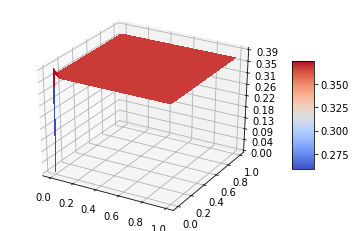

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

x=np.arange(0,1,0.01)
t=x
ms_x, ms_t = np.meshgrid(x, t)

## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)
#true solution
usol = np.sin(a_1 * np.pi *ms_x) * np.sin(a_2 * np.pi * ms_t) #solution chosen for convinience  
#u_true = usol.flatten('F')[:,None] 

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

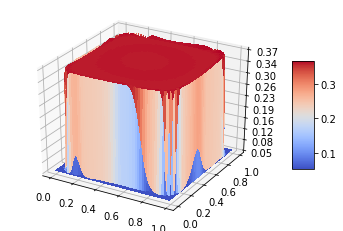

In [82]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

x1=np.arange(0,1,0.01)
x2=x1
ms_x1, ms_x2 = np.meshgrid(x1, x2)

## Just because meshgrid is used, we need to do the following adjustment
x1 = np.ravel(ms_x1).reshape(-1,1)
x2 = np.ravel(ms_x2).reshape(-1,1)
#true solution
usol = np.sin(a_1 * np.pi *ms_x1) * np.sin(a_2 * np.pi * ms_x2) #solution chosen for convinience  
#u_true = usol.flatten('F')[:,None] 

pt_x1 = Variable(torch.from_numpy(x1).float(), requires_grad=True).to(device)
pt_x2 = Variable(torch.from_numpy(x2).float(), requires_grad=True).to(device)
pt_u = net(pt_x1,pt_x2)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x1.shape)

surf = ax.plot_surface(ms_x1,ms_x2,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Text(0.5, 1.0, 'Predicted $\\hat u(x_1,x_2)$')

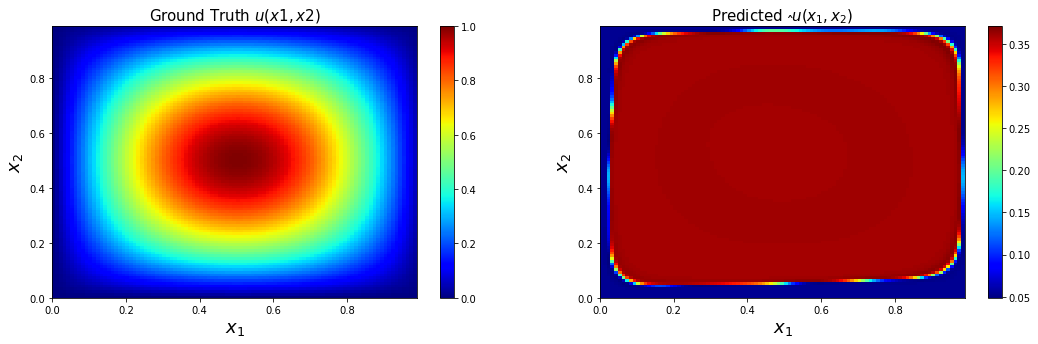

In [83]:
fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.pcolor(ms_x1, ms_x2, usol, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$', fontsize=18)
plt.ylabel(r'$x_2$', fontsize=18)
plt.title('Ground Truth $u(x1,x2)$', fontsize=15)


    # Prediction
plt.subplot(1, 2, 2)
plt.pcolor(ms_x1, ms_x2, ms_u, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$', fontsize=18)
plt.ylabel(r'$x_2$', fontsize=18)
plt.title('Predicted $\hat u(x_1,x_2)$', fontsize=15)

In [ ]:
usol.mean(), net(pt_x,pt_t).mean(), solution_EF.mean()

(0.40521806954768297,
 tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>),
 0.3673562928998836)